In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set()
import scipy.stats as stats
import datetime as dt

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [168]:
#conda install -c conda-forge geopy

In [169]:
def plot(x, city):
    fig, ax = plt.subplots(1,1,figsize=(20,20))
    ax.plot(x, label=city)
    ax.legend(loc='best', shadow=True, fancybox=True, fontsize=25, framealpha=0.5)
    plt.show


def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10),bins=20)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()
    
def impute_column(df, col_to_predict, feature_columns):
    """ Imputar valores faltantes de una columna a partir de un 
        modelo LR sobre columnas restantes
    """
    nan_rows = np.where(np.isnan(df[col_to_predict]))
    print(nan_rows)
    all_rows = np.arange(0,len(df))
    train_rows_idx = np.argwhere(~np.isin(all_rows,nan_rows)).ravel()
    pred_rows_idx =  np.argwhere(np.isin(all_rows,nan_rows)).ravel()
    
    X_train,y_train = df[feature_columns].iloc[train_rows_idx],df[col_to_predict].iloc[train_rows_idx]
    X_pred = df[feature_columns].iloc[pred_rows_idx]
      
    model = LinearRegression()
    model.fit(X_train,y_train)
    df[col_to_predict].iloc[pred_rows_idx] = model.predict(X_pred.values.reshape(1,-1))
    return df

def col_to_impute(df_1, df_missing, col):
    tmp_feature_cols = [x for x in feature_cols if x != col] 
    df_1.loc[df_missing[col].isna(),col] = np.nan
    df_1 = impute_column(df_1, col, tmp_feature_cols)
    return df_1

def Wind_Dir(df, dir):
    Wind_dir=pd.get_dummies(df[dir])
    wind_directions = [column for column in Wind_dir]
    north=dir+"_N"
    south=dir+"_S"
    west=dir+"_W"
    east=dir+"_E"
    df.insert(len(df.columns), north, 0)
    df.insert(len(df.columns), south, 0)
    df.insert(len(df.columns), west, 0)
    df.insert(len(df.columns), east, 0)
    for direction in wind_directions:
        if "N" in direction:
            df[north]+=Wind_dir[direction]
        if "S" in direction:
            df[south]+=Wind_dir[direction]
        if "W" in direction:
            df[west]+=Wind_dir[direction]
        if "E" in direction:
            df[east]+=Wind_dir[direction]
    
    df=df.drop(dir, axis=1)
    return df

def promedio(df, v1, v2, nombre, skipna):
    df_prom=df[[v1, v2]]
    df[nombre] = df_prom.mean(axis=1, skipna=skipna)
    return df

def outlier_diagnostic_plots(df, variable, dist):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    sns.histplot(df[variable], bins=30,ax=axes[0])
    axes[0].set_title('Histograma')
    
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')
    upper_limit, lower_limit = find_skewed_boundaries(df, variable, dist)
    return upper_limit, lower_limit
    
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [289]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n


class Accuracy(Metric):
    def __call__(self, target, prediction):
        return np.mean(target == prediction, axis=0)


class Precision(Metric):
    def __call__(self, target, prediction):
        inverse_truth = np.where(target == 0, 1, 0)
        inverse_predictions = np.where(prediction == 0, 1, 0)
        TP = np.sum(prediction * target)
        TN = np.sum(inverse_predictions * inverse_truth)
        FN = np.sum(target * inverse_predictions)
        FP = np.sum(prediction * inverse_truth)
        return TP / (TP + FP)


class Recall(Metric):
    def __call__(self, target, prediction):
        inverse_truth = np.where(target == 0, 1, 0)
        inverse_predictions = np.where(prediction == 0, 1, 0)
        TP = np.sum(prediction * target)
        TN = np.sum(inverse_predictions * inverse_truth)
        FN = np.sum(target * inverse_predictions)
        FP = np.sum(prediction * inverse_truth)
        return TP / (TP + FN)

In [170]:
######### Carga datos de dataset
path = r"C:/Especializacion IA/2do_bim/tp/weatherAUS.csv"
df = pd.read_csv(path, sep=',',engine='python')

###### Creo la variable Rainfall_tomorrow. 
df['Rainfall_tomorrow']=df['Rainfall'].shift(-1)
#df['Rainfall_yesterday']=df['Rainfall'].shift(1)
max_date = df["Date"].max()
#min_date = df["Date"].min()
delete = np.where(df.Date==max_date)
### dropeo el primer dia y el ultimo del dataset porque no tienen informacion sobre la lluvia de ayer y de mañana respectivamente.
df = df.drop(df[(df['Date']==max_date)].index)
#df = df.drop(df[(df['Date']==min_date)].index)

In [171]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_tomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [172]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Rainfall_tomorrow
count,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135159.000000,143645.000000,142351.000000,142759.000000,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142153.000000
mean,12.195873,23.223176,2.361516,5.468616,7.611241,40.036564,14.044742,18.663164,68.877290,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,2.361242
std,6.398018,7.118770,8.479338,4.193871,3.785612,13.607212,8.915610,8.810276,19.029576,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,8.479084
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [173]:
print(pd.value_counts(df['RainTomorrow'], sort = True))

### PRoblema desbalanceado.

No     110281
Yes     31872
Name: RainTomorrow, dtype: int64


In [174]:
total_samples = len(df)
cities = pd.unique(df.Location)
total_cities = len(cities)
df_nans_per_city = pd.DataFrame(index=cities, columns=df.columns)
for city in cities:
    # Filas con y nulo
    df_city = df[df.Location==city]
    for column in df_nans_per_city.columns:
        nans = len(df_city[df_city[column].isna()])
        df_nans_per_city.loc[city][column]=int(100*nans/len(df_city))
df_nans_per_city.describe()

##### de acá se puede ver que Evaporation y Sunshine son variables muy difíciles de recuperar, puesto que para una gran cantidad de ciudades tienen ausencia del 100% de los datos.
### Las variables WindGustDir, WindGustSpeed, Pressure y Cloud tienen algunas ciudades con 100% de Nans. Serán dificiles de recuperar pero se cree que son variables importantes.

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_tomorrow
count,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
unique,1,1,6,5,10,20,17,10,10,17,...,10,10,10,26,26,6,8,10,10,10
top,0,0,0,0,0,100,100,1,1,2,...,0,0,0,100,100,0,0,0,0,0
freq,49,49,39,41,24,16,19,22,22,8,...,35,36,37,12,12,37,39,24,24,24


In [175]:
df=df.drop(["Evaporation", "Sunshine"], axis=1)
df.shape

(145412, 22)

In [176]:
# upper, lower = outlier_diagnostic_plots(df, "Pressure9am")
# print(upper, lower)
# upper, lower = outlier_diagnostic_plots(df, "Pressure3pm")
# print(upper, lower)
#df_rainfall = df[df.Rainfall>5]
#upper, lower = outlier_diagnostic_plots(df_rainfall, "Rainfall",2)
#print(upper, lower)
# upper, lower = outlier_diagnostic_plots(df, "Pressure9am")
# print(upper, lower)

# quantile_norm = QuantileTransformer(output_distribution= 'normal')
# data=np.array(df["MaxTemp"])
# data_norm = quantile_norm.fit_transform(data.reshape(-1, 1))
# fig,axes = plt.subplots(1,2,figsize=(18,4))
# axes[0].hist(data, bins=25);axes[0].set_title("Distribución original")
# axes[1].hist(data_norm, bins=25);axes[1].set_title("Redistribución normal")

In [177]:
##### Comienzo One Hot Encoding con algunas cuestiones del dataframe completo.
df["Month"]=pd.to_datetime(df["Date"]).dt.month
df=df.replace(to_replace="Yes", value=1)
df=df.replace(to_replace="No", value=0)

In [178]:
variables_categoricas=["Month","WindGustDir", "WindDir9am", "WindDir3pm"]
for variable in variables_categoricas:
    print(df.loc[:, variable].value_counts())

3     13361
5     13353
1     13236
6     12636
8     12028
10    12028
7     12025
11    11669
9     11640
4     11550
12    11093
2     10793
Name: Month, dtype: int64
W      9910
SE     9416
N      9313
SSE    9215
E      9178
S      9168
WSW    9064
SW     8965
SSW    8733
WNW    8247
NW     8116
ENE    8103
ESE    7371
NE     7133
NNW    6617
NNE    6547
Name: WindGustDir, dtype: int64
N      11754
SE      9283
E       9172
SSE     9109
NW      8746
S       8657
W       8454
SW      8421
NNE     8129
NNW     7976
ENE     7835
NE      7669
ESE     7628
SSW     7585
WNW     7410
WSW     7022
Name: WindDir9am, dtype: int64
SE     10837
W      10105
S       9924
WSW     9512
SSE     9397
SW      9353
N       8889
WNW     8865
NW      8608
ESE     8501
E       8469
NE      8262
SSW     8154
NNW     7866
ENE     7856
NNE     6588
Name: WindDir3pm, dtype: int64


<AxesSubplot:xlabel='Month', ylabel='Rainfall_tomorrow'>

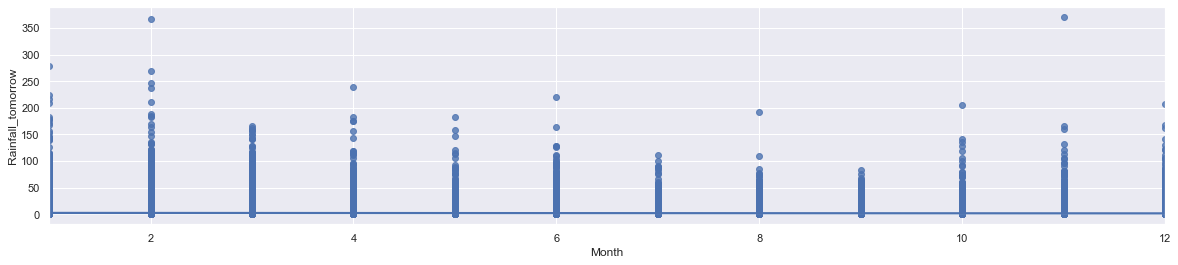

In [179]:
fig,axes = plt.subplots(1,1,figsize=(20,4))
sns.regplot(x="Month", y="Rainfall_tomorrow", data=df, order=1,ax=axes)

In [180]:
##### de los datos de lluvia por mes se puede ver para agrupar en: verano meses 12, 1, 2, otoño 3,4,5,6  invierno 7,8,9 , primavera 10,11

Month = pd.get_dummies(df["Month"])
df["Verano"]=Month[12]+Month[1]+Month[2]
df["Otoño"]=Month[3]+Month[4]+Month[5]+Month[6]
df["Invierno"]=Month[7]+Month[8]+Month[9]
df["Primavera"]=Month[10]+Month[11]
df=df.drop("Month", axis=1)

In [181]:
##### Evaluamos las variables categóricas de dirección de viento.
df = Wind_Dir(df, "WindGustDir")
df = Wind_Dir(df, "WindDir9am")
df = Wind_Dir(df, "WindDir3pm")
df.shape

(145412, 35)

In [182]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="gps_australia")

In [183]:
import re

df_locations = pd.DataFrame(columns=["City","Latitude","Longitude"])
i=0
for city in cities:
    ######## Hago una transformación de la ciudad en: "Australia"+ un split de la Ciudad donde tiene mayúsculas.
    ###### Esto es porque el nombre completo no es identificable por Geopy. Además, agrego "Australia" porque sino algunos resultados son de otros países.
    ### El único problema hasta ahí es PearceRAAF, que tiene muchas mayúsculas pero RAAF no debe separarse, entonces hago un chequeo de la longitud del String.
    result=re.sub( r"([A-Z])", r" \1", city).split()
    new_city="Australia "
    for strn in result:
        if len(strn)>1:
            new_city=new_city+strn+" "
        else:
            new_city=new_city+strn
    location=geolocator.geocode(new_city)
    df_locations.loc[i]=[city, location.latitude,location.longitude]  
    i+=1

print(df_locations.head())


            City   Latitude   Longitude
0         Albury -36.080477  146.916280
1  BadgerysCreek -33.881667  150.744163
2          Cobar -31.498333  145.834444
3   CoffsHarbour -30.296241  153.113529
4          Moree -29.461720  149.840715


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

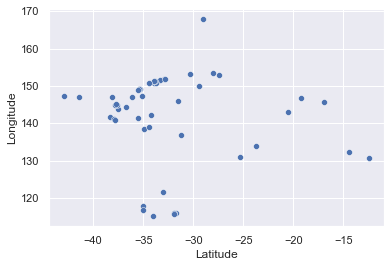

In [184]:
sns.scatterplot(x="Latitude", y="Longitude", data=df_locations)

            City   Latitude   Longitude  Cluster
0         Albury -36.080477  146.916280        4
1  BadgerysCreek -33.881667  150.744163        8
2          Cobar -31.498333  145.834444        8
3   CoffsHarbour -30.296241  153.113529        2
4          Moree -29.461720  149.840715        2


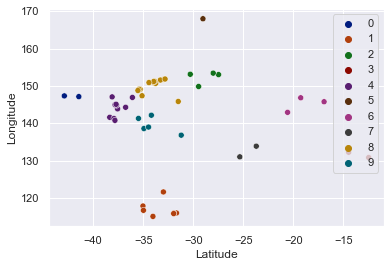

In [185]:
### uso Kmeans para clusterizar las ciudades.
X=df_locations.drop("City", axis=1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
sns.scatterplot(x="Latitude", y="Longitude", data=df_locations, hue=kmeans.labels_, palette="dark")
### joineo los labels a df_locations
df_locations = pd.concat([df_locations, pd.DataFrame(data=kmeans.labels_, columns=["Cluster"])], axis=1, join="inner")
print(df_locations.head())

In [186]:
for city in cities:
#    df=df.replace(to_replace=city, value="Cluster_"+str(np.array(df_locations.loc[df_locations.City==city]["Cluster"])))
    df=df.replace(to_replace=city, value=str(np.array(df_locations.loc[df_locations.City==city]["Cluster"])))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_W,WindGustDir_E,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir9am_E,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,WindDir3pm_E
0,2008-12-01,[4],13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,...,1,0,0,0,1,0,1,0,1,0
1,2008-12-02,[4],7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,...,1,0,1,0,1,0,0,1,1,0
2,2008-12-03,[4],12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,...,1,0,0,0,1,0,0,1,1,0
3,2008-12-04,[4],9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,...,0,1,0,1,0,1,0,0,0,1
4,2008-12-05,[4],17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,...,1,0,1,0,0,1,1,0,1,0


In [187]:
location = pd.get_dummies(df["Location"])
df= pd.concat([df, location], axis=1, join="inner")
df= df.drop("Location", axis=1)
df.shape
df.head()

,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]
0,2008-12-01,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,...,0,0,0,0,1,0,0,0,0,0
1,2008-12-02,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,...,0,0,0,0,1,0,0,0,0,0
2,2008-12-03,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,...,0,0,0,0,1,0,0,0,0,0
3,2008-12-04,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,...,0,0,0,0,1,0,0,0,0,0
4,2008-12-05,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,...,0,0,0,0,1,0,0,0,0,0


In [237]:
#df_1 = df.drop(["RainTomorrow", "Rainfall_tomorrow", "Date"], axis=1)
df_1 = df.sample(frac=1)
df_1 = df_1.reset_index(drop=True)
print(df_1.head())
y=df_1["RainTomorrow"]
X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size=0.2, random_state=1,shuffle=False)
X_train.shape, X_test.shape

         Date  MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
0  2017-02-18     10.2     17.2       4.6           48.0          19.0   
1  2017-04-12     10.8     19.3       0.0           22.0           9.0   
2  2013-10-15      9.3     22.0       0.0           31.0           6.0   
3  2011-02-11     21.0     26.5       3.8           33.0          11.0   
4  2016-02-26     15.3     20.2       0.8           44.0          20.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  ...  [0]  [1]  [2]  \
0          26.0         60.0         67.0       1011.5  ...    0    0    0   
1           9.0         79.0         64.0       1026.5  ...    0    0    0   
2          13.0         67.0         66.0       1020.6  ...    0    1    0   
3           6.0         97.0         76.0       1010.5  ...    0    0    0   
4          24.0         68.0         64.0       1019.0  ...    0    0    0   

   [3]  [4]  [5]  [6]  [7]  [8]  [9]  
0    0    1    0    0    0    0    0  
1    0  

((116329, 44), (29083, 44))

In [189]:
X_train.head()

,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]
0,2013-09-12,12.8,19.2,22.0,43.0,19.0,22.0,75.0,65.0,1015.8,...,0,1,0,0,0,0,0,0,0,0
1,2011-06-23,5.6,14.0,1.8,35.0,17.0,15.0,94.0,66.0,1020.8,...,0,0,0,0,0,0,0,0,1,0
2,2016-06-17,6.2,15.3,4.2,33.0,11.0,11.0,93.0,87.0,1015.7,...,0,0,0,0,0,0,0,0,1,0
3,2013-05-30,11.7,21.4,0.0,24.0,15.0,7.0,90.0,67.0,1029.3,...,0,0,0,0,0,0,0,0,1,0
4,2010-12-12,20.6,27.1,8.8,30.0,13.0,13.0,82.0,65.0,1006.6,...,0,0,1,0,0,0,0,0,0,0


In [190]:
clusters=pd.unique(df_locations["Cluster"])
df_nans_per_cluster = pd.DataFrame(index=clusters, columns=X_train.columns)
for cluster in clusters:
    # Filas con y nulo
    clust=str(np.array([cluster]))
    df_cluster = X_train[X_train[clust]==1]
    for column in df_nans_per_cluster.columns:
        nans = len(df_cluster[df_cluster[column].isna()])
        df_nans_per_cluster.loc[cluster][column]=int(100*nans/len(df_cluster))
df_nans_per_cluster[["Rainfall","WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud3pm", "Pressure9am", "Pressure3pm", "MaxTemp", "MinTemp"]]

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,Pressure9am,Pressure3pm,MaxTemp,MinTemp
4,2,1,0,0,2,2,27,28,2,2,1,1
8,2,13,2,3,2,4,49,51,24,24,0,1
2,2,5,3,3,0,0,35,34,2,2,0,0
5,1,1,0,0,0,0,2,2,0,0,0,0
6,1,0,0,0,0,0,30,32,0,0,0,0
9,1,0,0,0,0,0,38,45,0,0,0,0
1,2,16,0,4,1,5,47,50,15,15,0,0
0,0,1,0,0,0,0,55,55,18,18,0,0
7,1,2,0,0,0,0,33,32,0,0,0,0
3,0,1,0,0,1,17,0,15,0,0,0,1


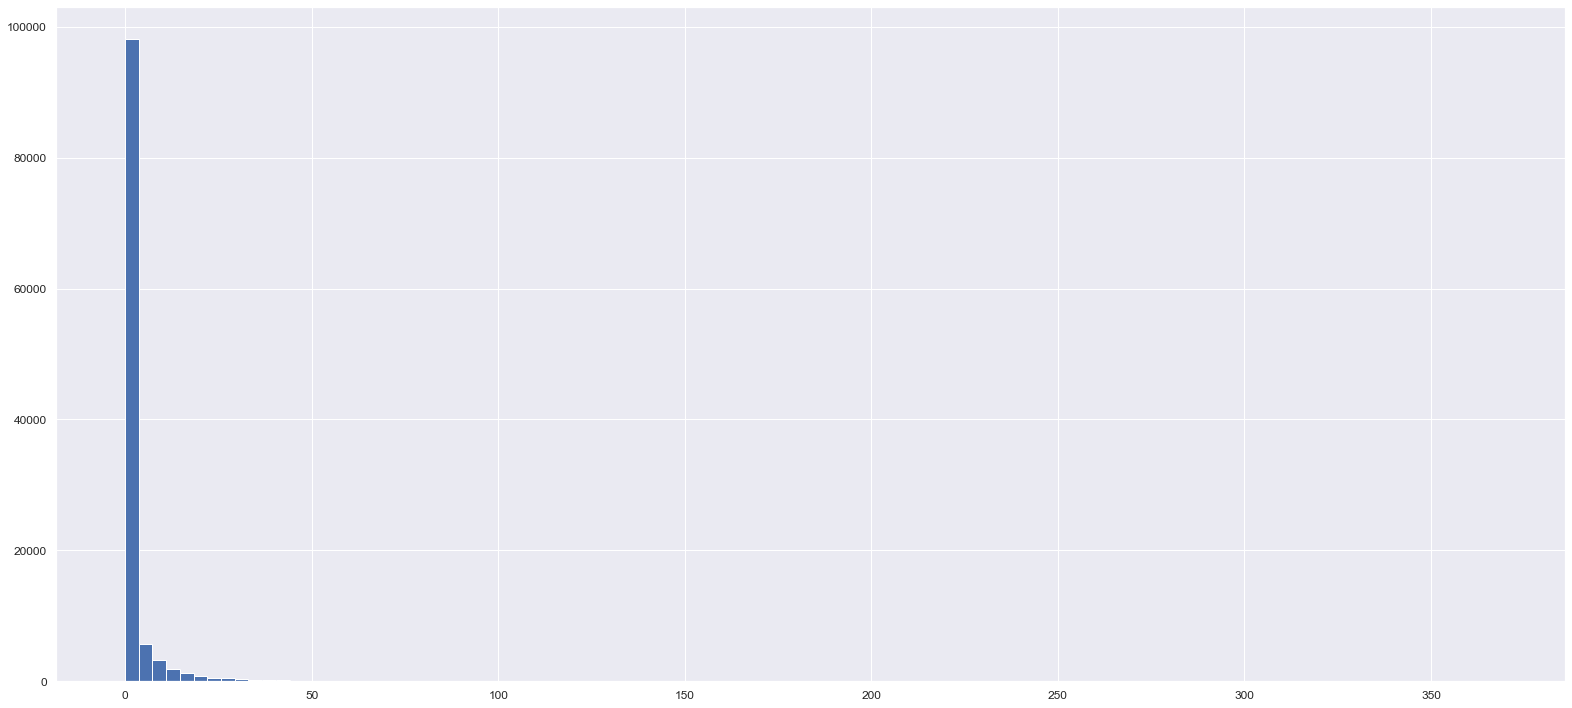

In [191]:
fig = X_train["Rainfall"].hist(xlabelsize=12, ylabelsize=12,figsize=(22,10),bins=100)
plt.tight_layout()
plt.show()

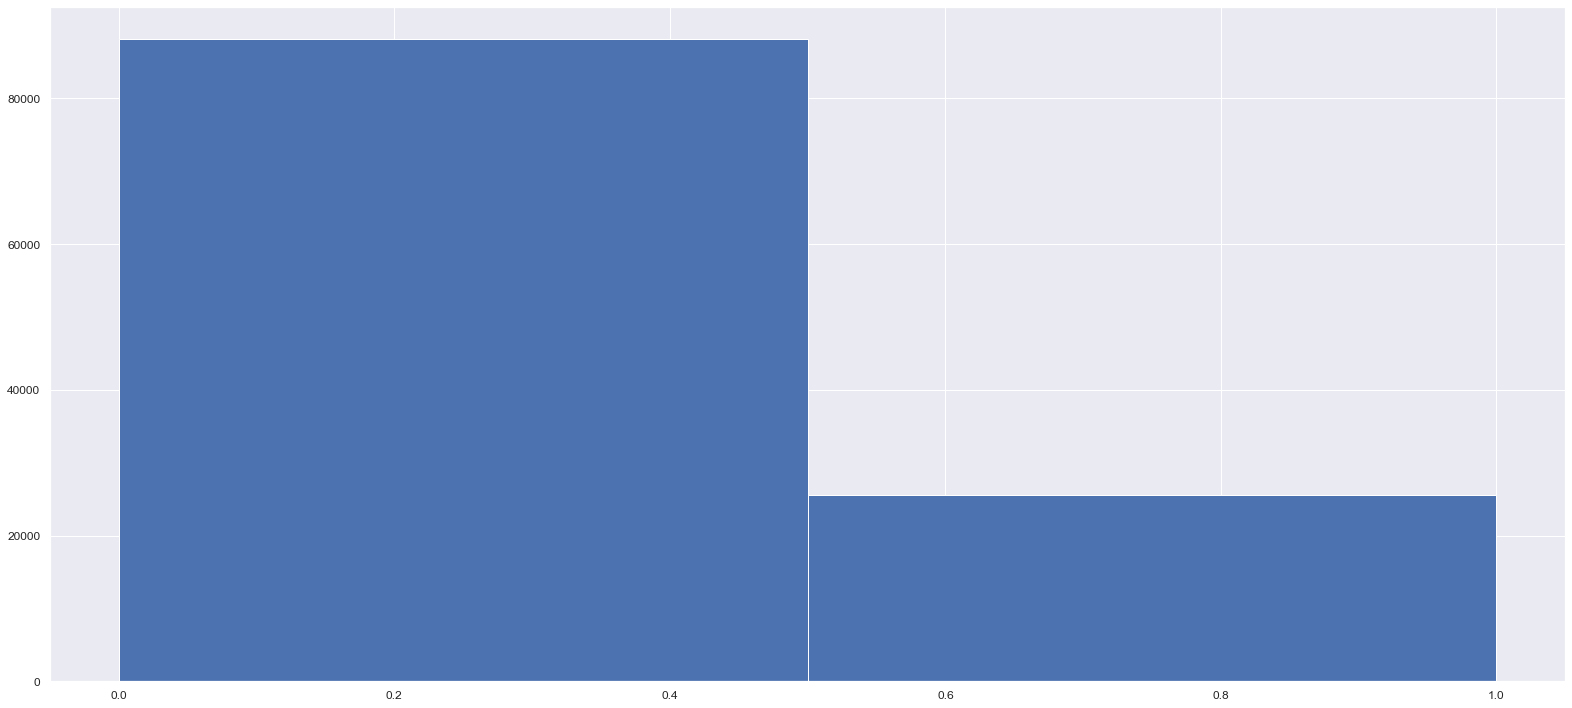

In [192]:
fig = X_train["RainTomorrow"].hist(xlabelsize=12, ylabelsize=12,figsize=(22,10),bins=2)
plt.tight_layout()
plt.show()

In [193]:
X_train.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Rainfall_tomorrow', 'Verano',
       'Otoño', 'Invierno', 'Primavera', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindGustDir_E', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir9am_E', 'WindDir3pm_N', 'WindDir3pm_S',
       'WindDir3pm_W', 'WindDir3pm_E', '[0]', '[1]', '[2]', '[3]', '[4]',
       '[5]', '[6]', '[7]', '[8]', '[9]'],
      dtype='object')

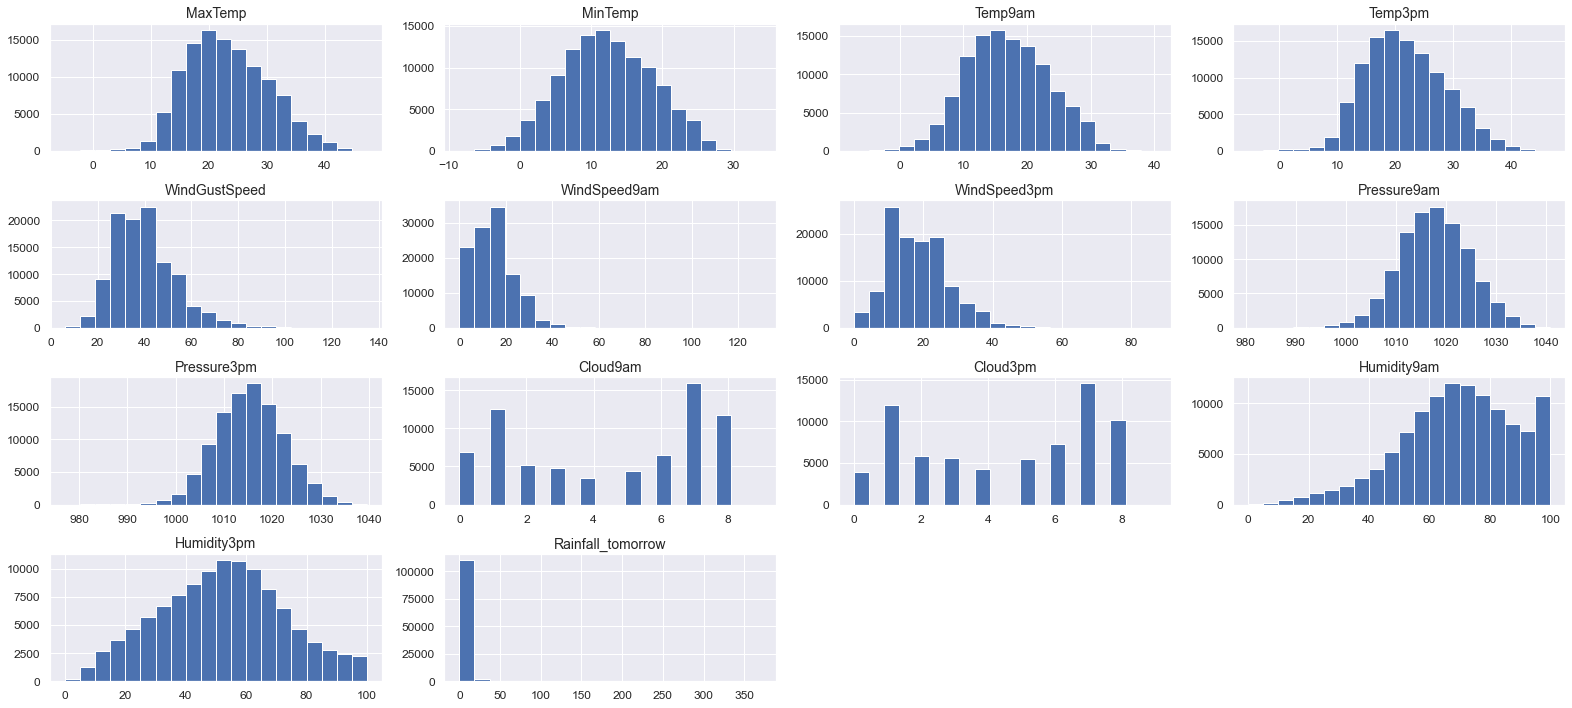

In [194]:
feature_cols=["MaxTemp","MinTemp", "Temp9am", "Temp3pm", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Humidity9am", "Humidity3pm","Rainfall_tomorrow"]
df_2=X_train[feature_cols]
display_dataset_distributions(df_2)

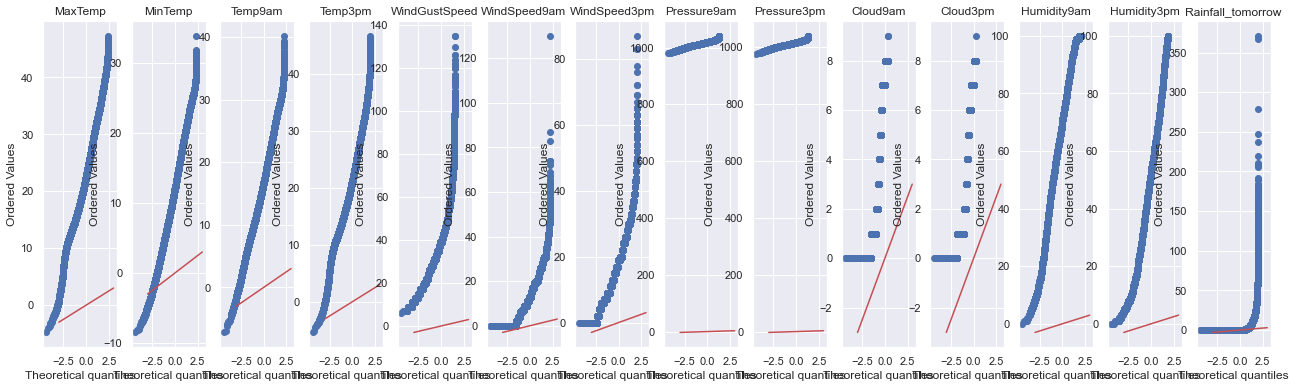

In [195]:
fig,axes=plt.subplots(1,len(feature_cols),figsize=(22,6))
x=np.linspace(-3,3,3)
i=0
for col in feature_cols:
    stats.probplot(df_2[col], dist="norm", plot=axes[i])
    axes[i].plot(x, x, 'r')
    axes[i].set_title(col)
    i+=1

In [196]:
def quantile_transformer(df, variable):  
    quantile_norm = QuantileTransformer(output_distribution= 'normal')
    data=np.array(df[variable])
    data_norm = quantile_norm.fit_transform(data.reshape(-1, 1))
    fig,axes = plt.subplots(1,2,figsize=(18,4))
    axes[0].hist(data, bins=25);axes[0].set_title("Distribución original")
    axes[1].hist(data_norm, bins=25);axes[1].set_title("Redistribución normal")
    return data_norm

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

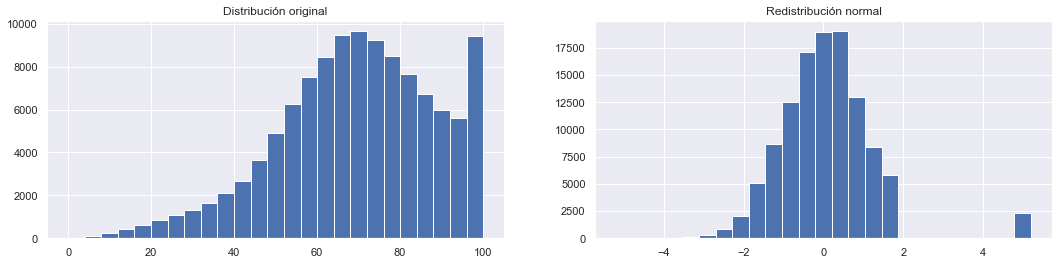

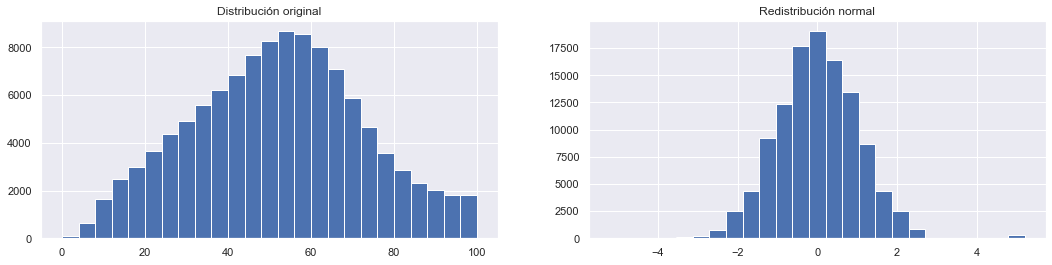

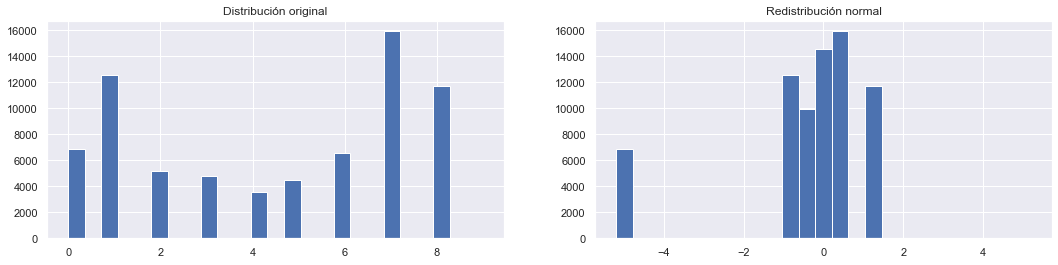

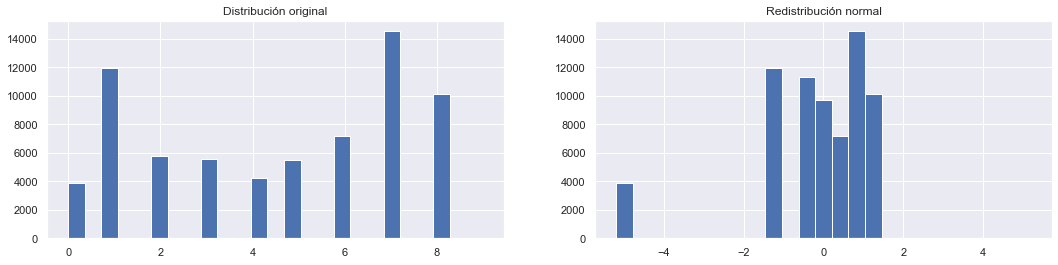

In [197]:
# Las variables de teperatura y presión parecen tener distribución normal. No así Humedad y Nublados.
X_train.loc[:,"Hum9am_v2"]=quantile_transformer(X_train, "Humidity9am")
X_train.loc[:,"Hum3pm_v2"]=quantile_transformer(X_train, "Humidity3pm")
X_train.loc[:,"Cloud9am_v2"]=quantile_transformer(X_train, "Cloud9am")
X_train.loc[:,"Cloud3pm_v2"]=quantile_transformer(X_train, "Cloud3pm")

(14, 14)


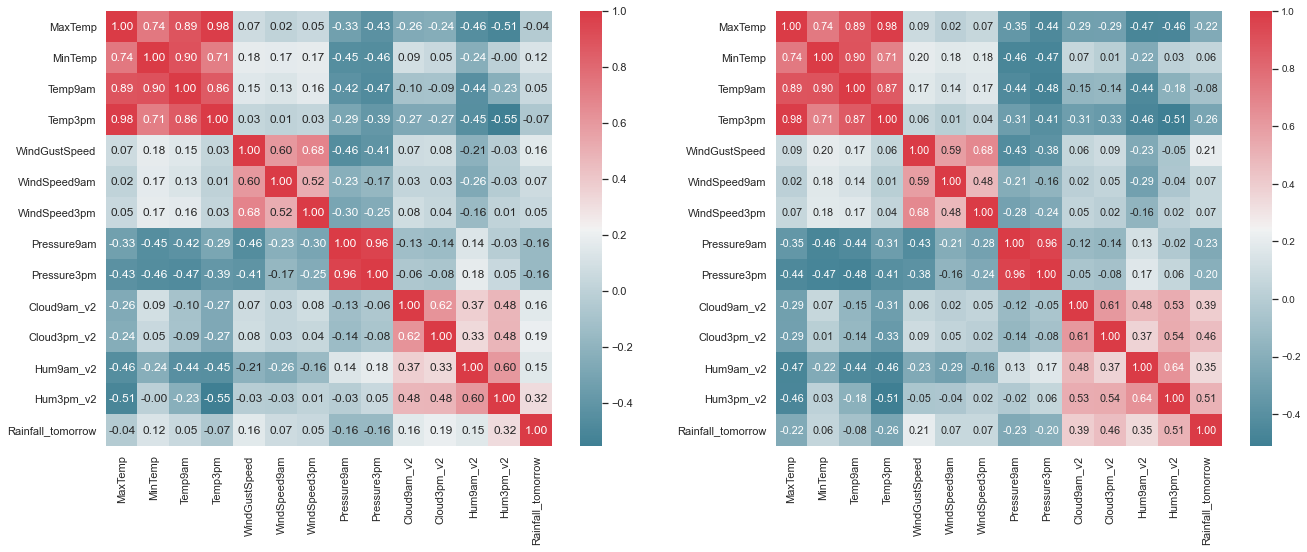

In [198]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))
feature_cols=["MaxTemp","MinTemp", "Temp9am", "Temp3pm", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm","Pressure9am", "Pressure3pm", "Cloud9am_v2", "Cloud3pm_v2", "Hum9am_v2", "Hum3pm_v2","Rainfall_tomorrow"]
df_3=X_train[feature_cols]
corr = df_3.corr()
print(corr.shape)
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f", ax=ax[0])
sns.set(font_scale=0.9)
corr_2 = df_3.corr(method='spearman')
sns.heatmap(corr_2, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f", ax=ax[1])
sns.set(font_scale=0.9)
########## Se observa alta correlacion entre las temperaturas y entre presiones, pero no entre nublados y humedades. Además, Rainfall_Tomorrow está lejos de ser normal.
### Esto nos indica que usaremos una variable de temperatura, una de presión y ambas de nublado/humedad.

In [199]:
X_train=X_train.drop(["Cloud9am_v2", "Cloud3pm_v2", "Hum9am_v2", "Hum3pm_v2"], axis=1)

<AxesSubplot:xlabel='Humidity9am', ylabel='Humidity3pm'>

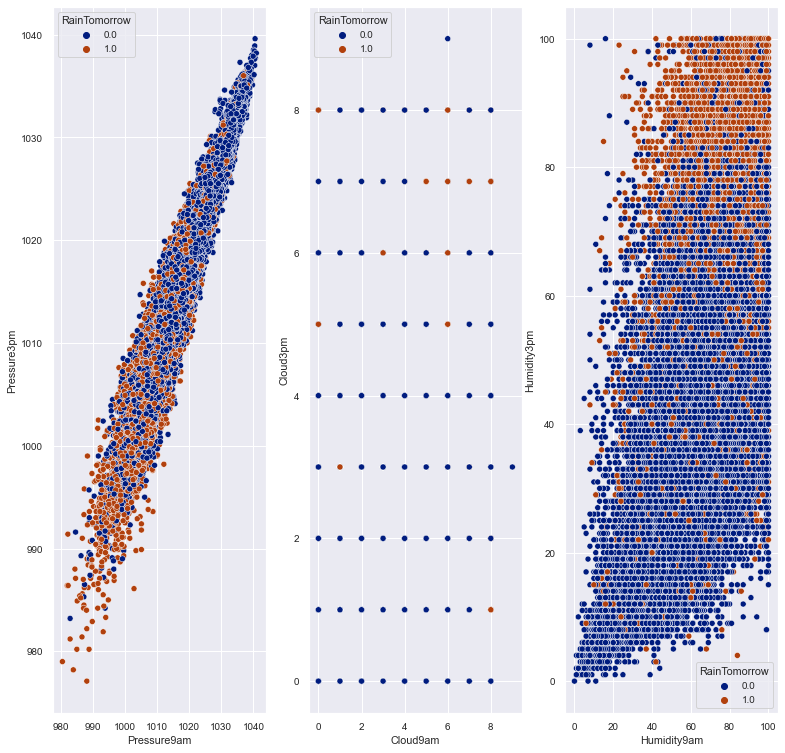

In [200]:
fig,axes=plt.subplots(1,3,figsize=(13,13))
sns.scatterplot(x="Pressure9am", y="Pressure3pm", data=X_train, ax=axes[0], hue="RainTomorrow", palette="dark")
sns.scatterplot(x="Cloud9am", y="Cloud3pm", data=X_train, ax=axes[1], hue="RainTomorrow", palette="dark")
sns.scatterplot(x="Humidity9am", y="Humidity3pm", data=X_train, ax=axes[2], hue="RainTomorrow", palette="dark")
###### en las presiones se observa algo interesante que es, para presiones 9am y 3pm menores a 1013 aprox, hay mas puntos de lluvia mientras que para mayores, practicamente no llueve.
### estan fuertemente relacionadas así que se intentará usar una sola presión que contenga información de ambas (por ejemplo, usar la de las 3pm excepto cuando sea NaN)

#### en el caso del nublado no se ve ninguna correlación.
### en el caso de la humedad, la variable de las 9am no parece decir mucho mientras que la de las 3pm refleja bastante bien el comportamiento de la salida. Pero no hay correlacion entre ellas, al menos lineal.

<AxesSubplot:xlabel='Temp9am', ylabel='Temp3pm'>

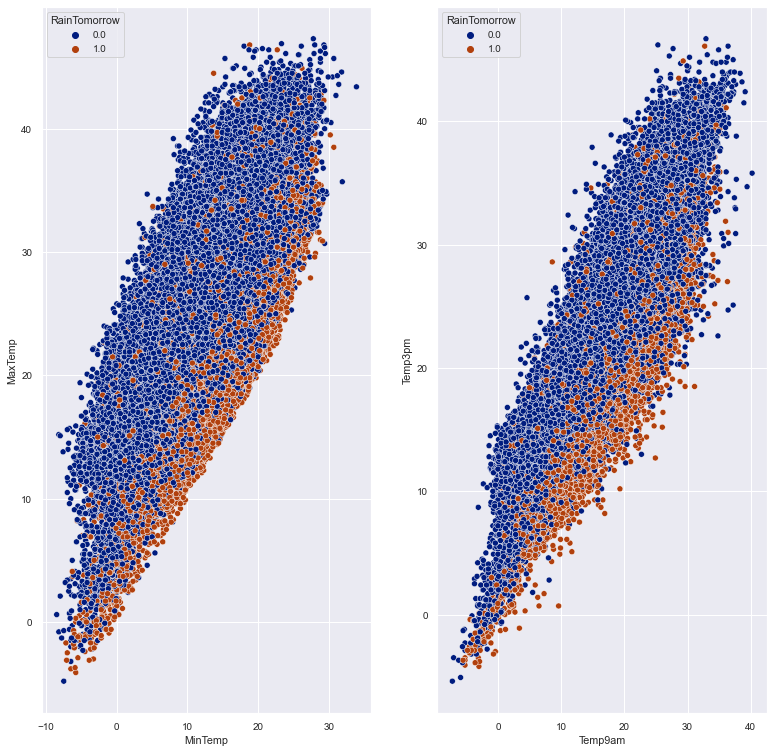

In [201]:
fig,axes=plt.subplots(1,2,figsize=(13,13))
sns.scatterplot(x="MinTemp", y="MaxTemp", data=X_train, ax=axes[0], hue="RainTomorrow", palette="dark")
sns.scatterplot(x="Temp9am", y="Temp3pm", data=X_train, ax=axes[1], hue="RainTomorrow", palette="dark")

#####3 ambos parecen casos linealmente separables. Parece ser importante la relación que hay entre ellas.

<AxesSubplot:xlabel='WindSpeed9am', ylabel='WindSpeed3pm'>

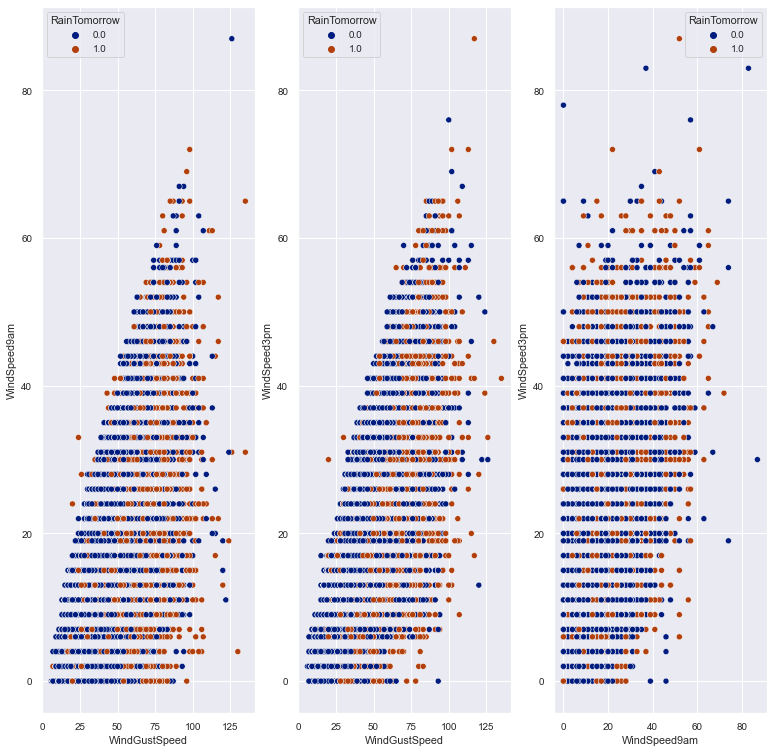

In [202]:
fig,axes=plt.subplots(1,3,figsize=(13,13))
sns.scatterplot(x="WindGustSpeed", y="WindSpeed9am", data=X_train, ax=axes[0], hue="RainTomorrow", palette="dark")
sns.scatterplot(x="WindGustSpeed", y="WindSpeed3pm", data=X_train, ax=axes[1], hue="RainTomorrow", palette="dark")
sns.scatterplot(x="WindSpeed9am", y="WindSpeed3pm", data=X_train, ax=axes[2], hue="RainTomorrow", palette="dark")

In [203]:
#X_train=promedio(X_train,"MinTemp", "MaxTemp","TempMedia",False)
#X_train=promedio(X_train, "Temp9am", "Temp3pm", "TempMedia_v2",False)

In [238]:
X_train["Amplitud_Temp"]=(X_train["MaxTemp"]-X_train["MinTemp"])

<ipython-input-238-2eed2c0020ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Amplitud_Temp"]=(X_train["MaxTemp"]-X_train["MinTemp"])


<AxesSubplot:xlabel='RainTomorrow', ylabel='Amplitud_Temp'>

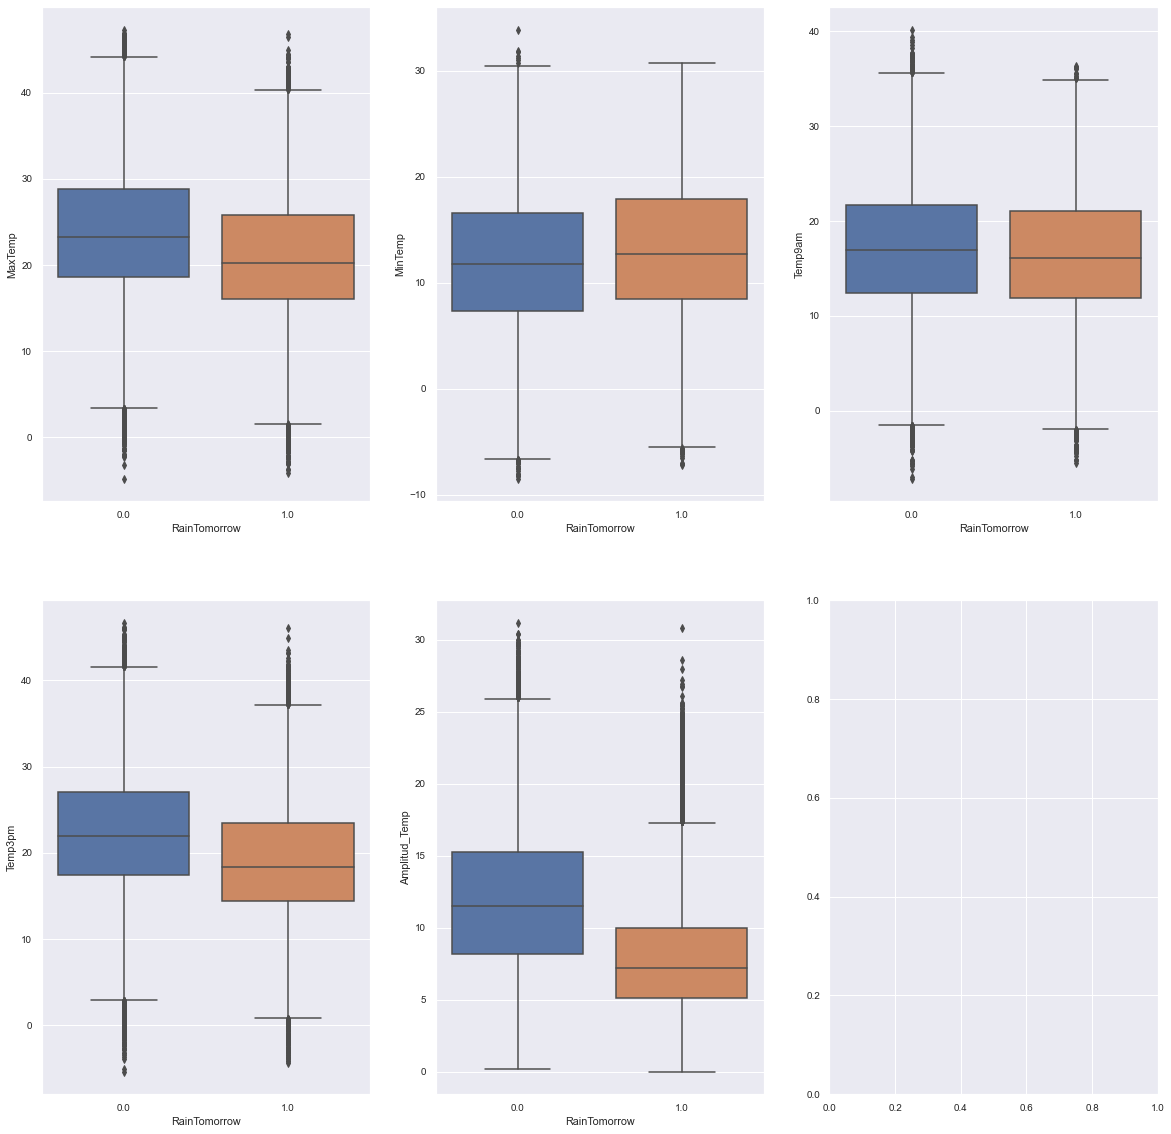

In [205]:
fig, ax = plt.subplots(2, 3, figsize=(20, 20))
sns.boxplot(x='RainTomorrow', y='MaxTemp', data=X_train, ax=ax[0,0])
sns.boxplot(x='RainTomorrow', y='MinTemp', data=X_train, ax=ax[0,1])
sns.boxplot(x='RainTomorrow', y='Temp9am', data=X_train, ax=ax[0,2])
sns.boxplot(x='RainTomorrow', y='Temp3pm', data=X_train, ax=ax[1,0])
sns.boxplot(x='RainTomorrow', y='Amplitud_Temp', data=X_train, ax=ax[1,1])

#### la mejor variable para predecir parecen las restas de Max y Min Temp. Nos quedaremos con la que tenga menos Nans.

<AxesSubplot:xlabel='RainTomorrow', ylabel='Humidity3pm'>

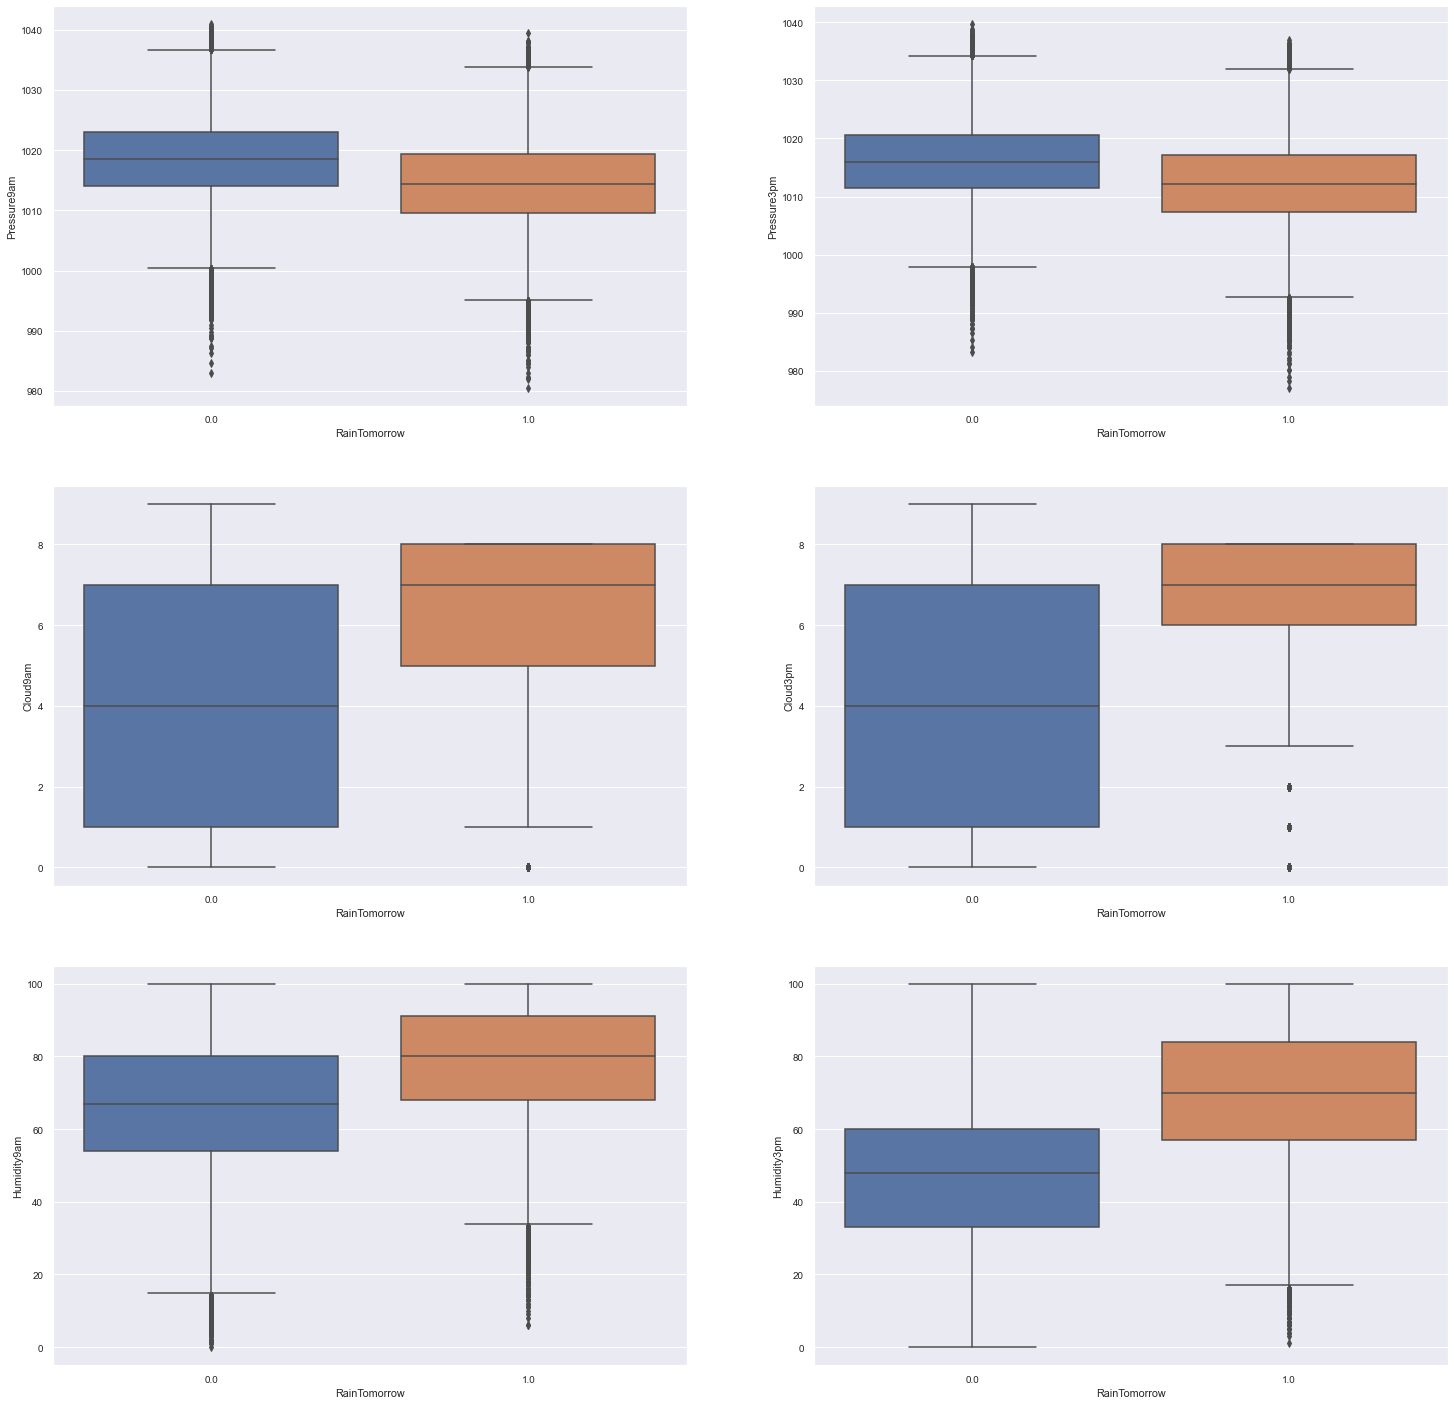

In [206]:
fig, ax = plt.subplots(3, 2, figsize=(25, 25))
sns.boxplot(x='RainTomorrow', y='Pressure9am', data=X_train, ax=ax[0,0])
sns.boxplot(x='RainTomorrow', y='Pressure3pm', data=X_train, ax=ax[0,1])
sns.boxplot(x='RainTomorrow', y='Cloud9am', data=X_train, ax=ax[1,0])
sns.boxplot(x='RainTomorrow', y='Cloud3pm', data=X_train, ax=ax[1,1])
sns.boxplot(x='RainTomorrow', y='Humidity9am', data=X_train, ax=ax[2,0])
sns.boxplot(x='RainTomorrow', y='Humidity3pm', data=X_train, ax=ax[2,1])

###### Como habíamos visto anteriormente, no hay una preferencia por presión o nublado pero sí de Humedad.

In [239]:
X_train = promedio(X_train, "Pressure9am", "Pressure3pm", "Pressure", True)
X_train=X_train.drop(["Pressure9am", "Pressure3pm"], axis=1)
X_train.columns

<ipython-input-169-fbddc21cdbf6>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nombre] = df_prom.mean(axis=1, skipna=skipna)


Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'Rainfall_tomorrow', 'Verano', 'Otoño', 'Invierno',
       'Primavera', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindGustDir_E', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir9am_E', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W',
       'WindDir3pm_E', '[0]', '[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]',
       '[8]', '[9]', 'Amplitud_Temp', 'Pressure'],
      dtype='object')

<AxesSubplot:xlabel='RainTomorrow', ylabel='WindSpeed3pm'>

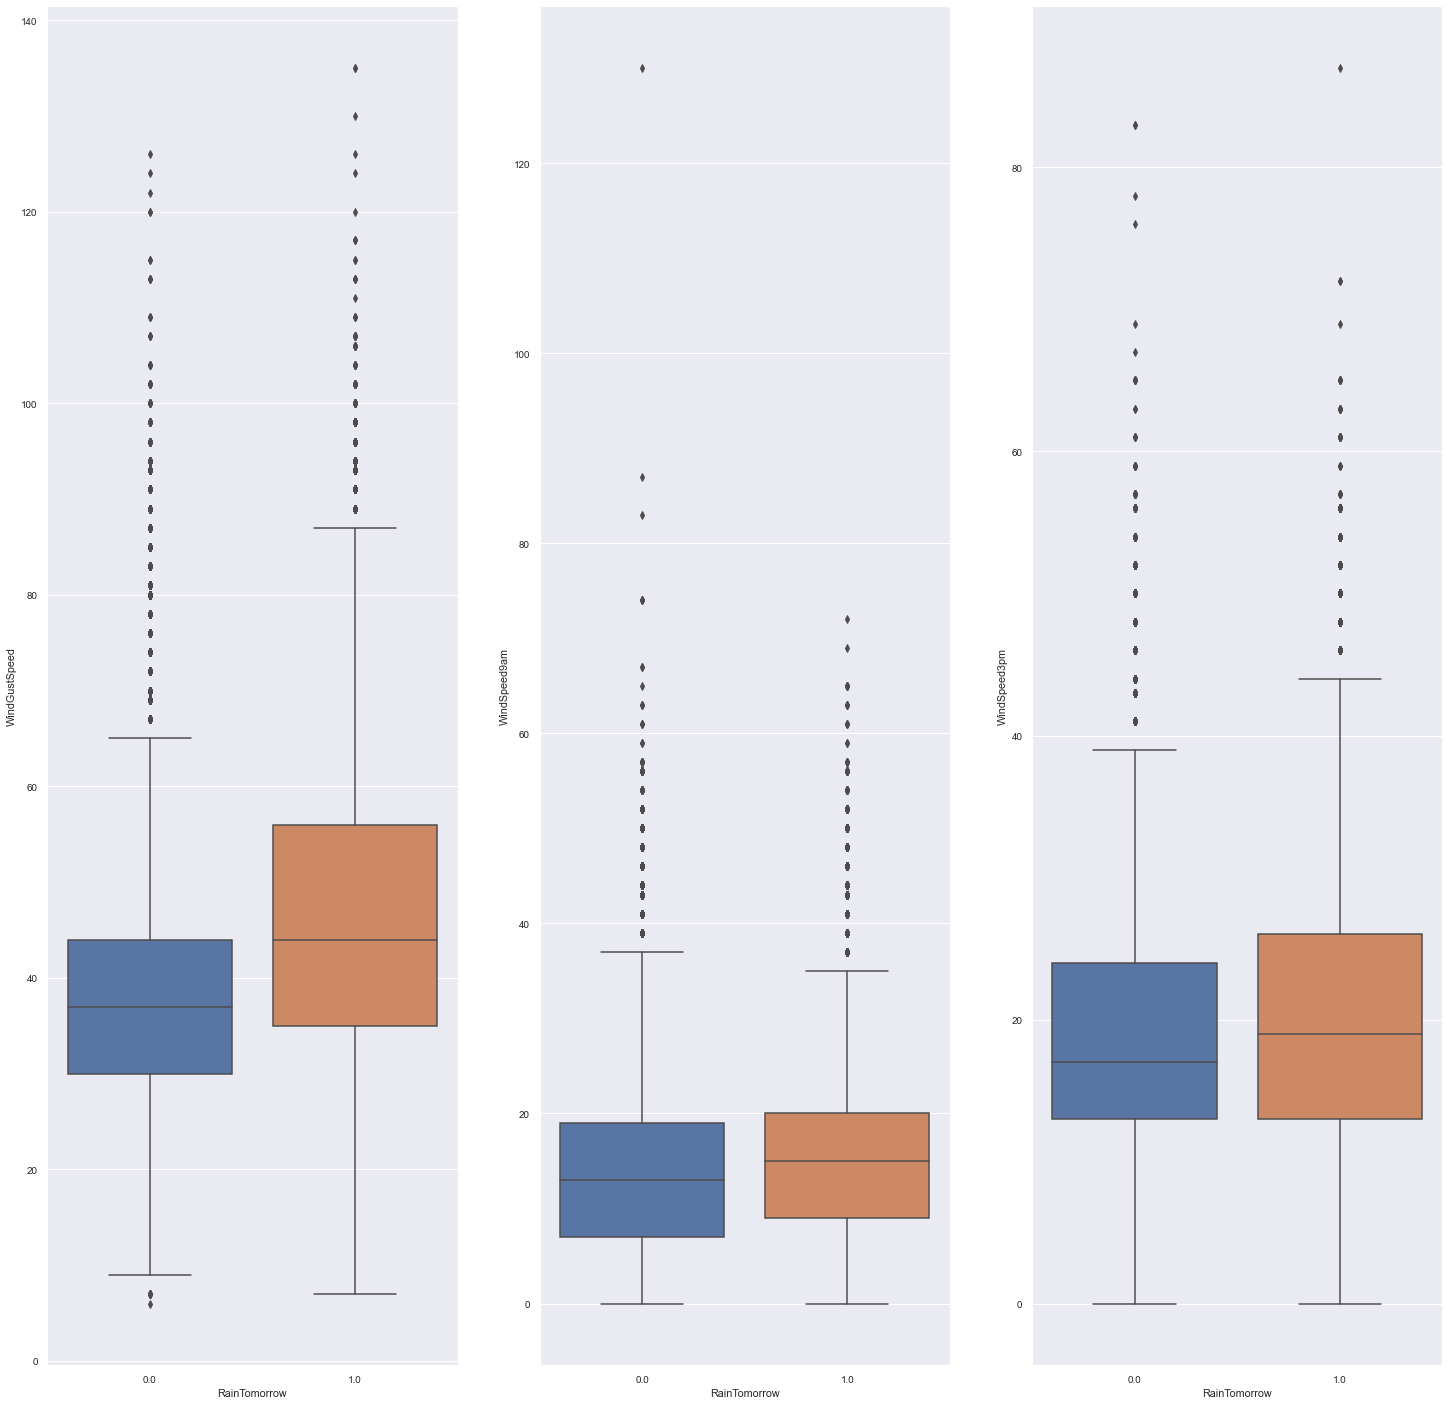

In [208]:
fig, ax = plt.subplots(1, 3, figsize=(25, 25))
sns.boxplot(x='RainTomorrow', y='WindGustSpeed', data=X_train, ax=ax[0])
sns.boxplot(x='RainTomorrow', y='WindSpeed9am', data=X_train, ax=ax[1])
sns.boxplot(x='RainTomorrow', y='WindSpeed3pm', data=X_train, ax=ax[2])

<AxesSubplot:xlabel='RainTomorrow', ylabel='WindGustDir_W'>

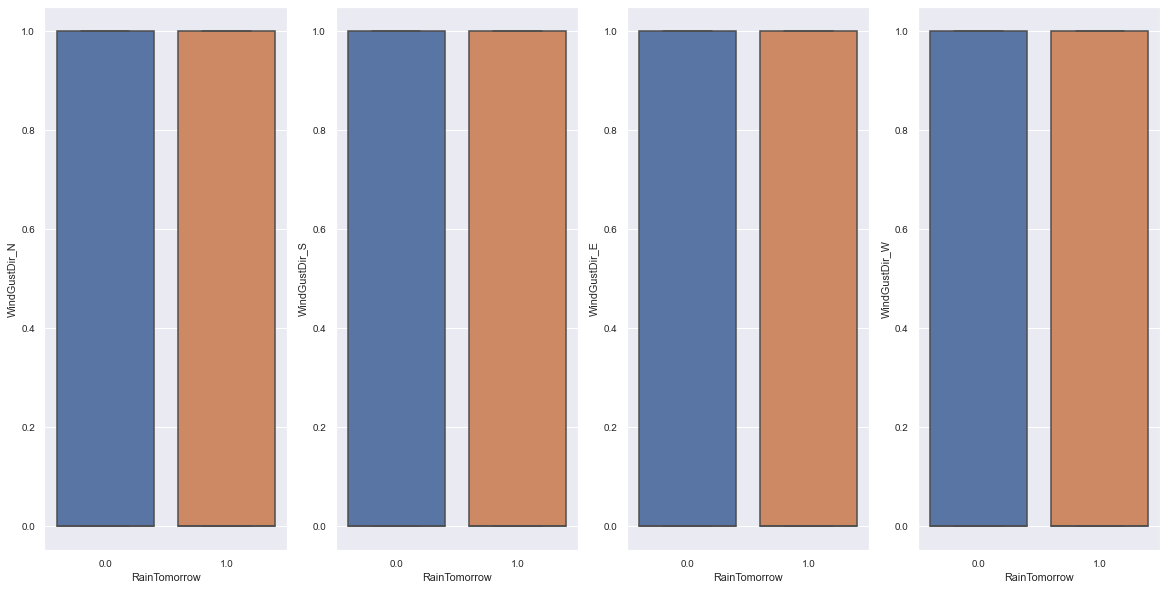

In [209]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
sns.boxplot(x='RainTomorrow', y='WindGustDir_N', data=X_train, ax=ax[0])
sns.boxplot(x='RainTomorrow', y='WindGustDir_S', data=X_train, ax=ax[1])
sns.boxplot(x='RainTomorrow', y='WindGustDir_E', data=X_train, ax=ax[2])
sns.boxplot(x='RainTomorrow', y='WindGustDir_W', data=X_train, ax=ax[3])

In [240]:
##### Para seguir analizando relaciones entre datos es necesario ya imputar los datos faltantes
##### Comienzo por dropear Cloud9am y Cloud3pm. Tienen una cantidad de datos faltantes muy importante.
X_train=X_train.drop(["Cloud9am","Cloud3pm"],axis=1)

In [241]:
### Termino de acomodar las columnas de X_train. Saco además RainTomorrow y Rainfall_tomorrow.
X_train=X_train.drop(["Date","MinTemp","MaxTemp","Temp9am","Temp3pm"],axis=1)

In [242]:
X_train.columns

Index(['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'RainToday', 'RainTomorrow',
       'Rainfall_tomorrow', 'Verano', 'Otoño', 'Invierno', 'Primavera',
       'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindGustDir_E',
       'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir9am_E',
       'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'WindDir3pm_E', '[0]',
       '[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]', '[8]', '[9]',
       'Amplitud_Temp', 'Pressure'],
      dtype='object')

In [243]:
#### no voy a imputar valores correspondientes a lluvias. De eso se encargará el modelo a entrenar.
X_train=X_train.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
X_train.shape

(112605, 37)

25.45 -3.749999999999999


((112607, 37), (112276, 37))

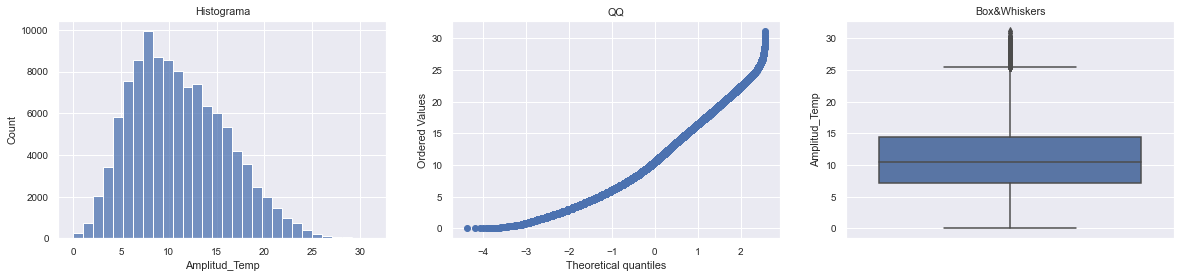

In [214]:
########3 OUTLIERS
upper,lower=outlier_diagnostic_plots(X_train, "Amplitud_Temp", 1.5)
print(upper,lower)
outliers = np.where(X_train['Amplitud_Temp'] > upper, True,
                    np.where(X_train['Amplitud_Temp'] < lower, True, False))
xtrain_trimmed = X_train.loc[~outliers, ]
X_train.shape, xtrain_trimmed.shape

1035.25 997.6500000000001


((112607, 37), (111769, 37))

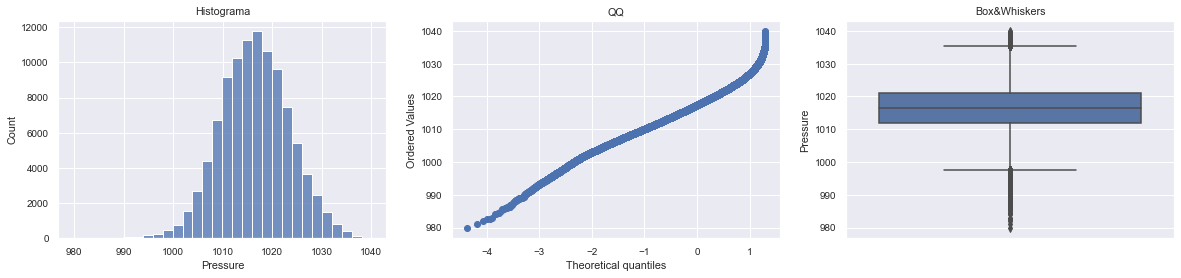

In [215]:
########3 OUTLIERS
upper,lower=outlier_diagnostic_plots(X_train, "Pressure", 1.5)
print(upper, lower)
outliers = np.where(X_train['Pressure'] > upper, True,
                    np.where(X_train['Pressure'] < lower, True, False))
xtrain_trimmed = X_train.loc[~outliers, ]
X_train.shape, xtrain_trimmed.shape

73.5 5.5


((112607, 37), (110254, 37))

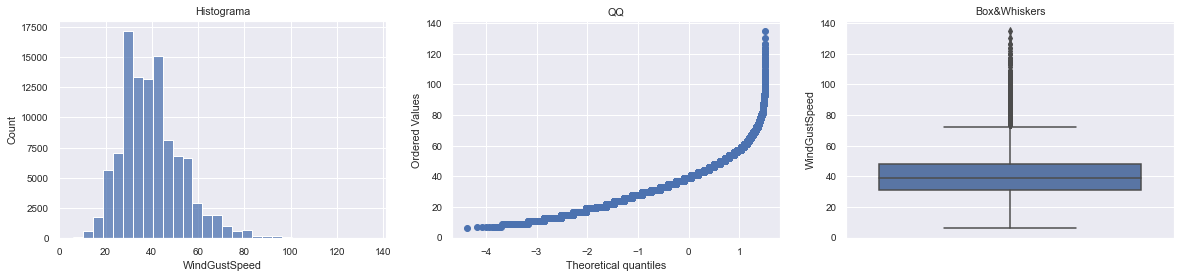

In [216]:
########3 OUTLIERS
upper,lower=outlier_diagnostic_plots(X_train, "WindGustSpeed", 1.5)
print(upper, lower)
outliers = np.where(X_train['WindGustSpeed'] > upper, True,
                    np.where(X_train['WindGustSpeed'] < lower, True, False))
xtrain_trimmed = X_train.loc[~outliers, ]
X_train.shape, xtrain_trimmed.shape

2.4000000000000004 -1.6


((112607, 37), (93937, 37))

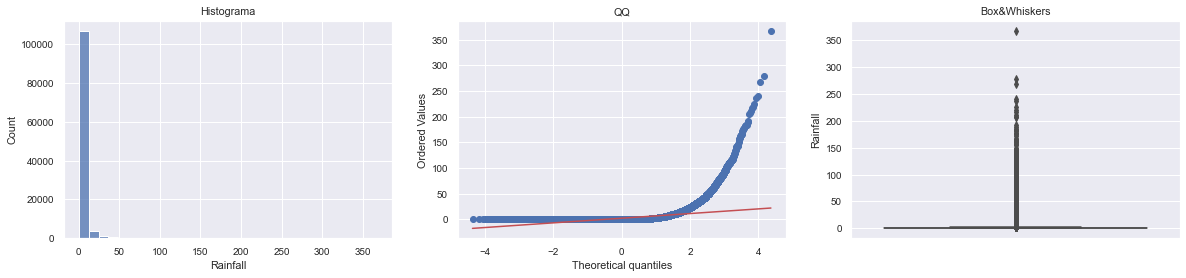

In [217]:
########3 OUTLIERS
upper,lower=outlier_diagnostic_plots(X_train, "Rainfall", 2)
print(upper, lower)
outliers = np.where(X_train["Rainfall"] > upper, True,
                    np.where(X_train["Rainfall"] < lower, True, False))
xtrain_trimmed = X_train.loc[~outliers, ]
X_train.shape, xtrain_trimmed.shape

In [218]:
cluster=1
"["+str(cluster)+"]"

'[1]'

In [219]:
columns=["Pressure","Amplitud_Temp"]
X_train[columns]

,Pressure,Amplitud_Temp
0,1016.35,6.4
1,1021.20,8.4
2,1014.90,9.1
3,1027.60,9.7
4,1006.00,6.5
...,...,...
116324,1014.10,8.6
116325,1016.75,22.4
116326,1016.00,19.1
116327,1016.50,15.4


9         46.0
34        26.0
43        54.0
45        61.0
46        39.0
          ... 
116300    48.0
116301    35.0
116308    37.0
116310    70.0
116325    33.0
Name: WindGustSpeed, Length: 23452, dtype: float64

In [221]:
from sklearn.impute import SimpleImputer

def impute_by_median(X_t, column):
    X_train=X_t.copy()
    outlier_diagnostic_plots(X_train, column, 1.5)
    imputer = SimpleImputer(strategy='median',add_indicator=True)
    X_train[column] = imputer.fit_transform(X_train[column].values.reshape(-1, 1))
    outlier_diagnostic_plots(X_train, column, 1.5)
    return X_train, imputer

In [222]:
from sklearn.impute import SimpleImputer

def impute_by_median2(X_t, column):
    X_train=X_t.copy()
    imputer = SimpleImputer(strategy='median',add_indicator=True)
    for cluster in clusters:
        clase=str(np.array([cluster]))
        X2 = X_train[X_train[clase]==True][column]
        X2k = imputer.fit_transform(X2.values.reshape(-1,1))
        X_train[X_train[clase]==True].loc[:,column]=X2k[:,0]
        
    return X_train, imputer

Rainfall                 0
WindGustSpeed            0
WindSpeed9am             0
WindSpeed3pm             0
Humidity9am              0
Humidity3pm           2865
RainToday                0
RainTomorrow             0
Rainfall_tomorrow        0
Verano                   0
Otoño                    0
Invierno                 0
Primavera                0
WindGustDir_N            0
WindGustDir_S            0
WindGustDir_W            0
WindGustDir_E            0
WindDir9am_N             0
WindDir9am_S             0
WindDir9am_W             0
WindDir9am_E             0
WindDir3pm_N             0
WindDir3pm_S             0
WindDir3pm_W             0
WindDir3pm_E             0
[0]                      0
[1]                      0
[2]                      0
[3]                      0
[4]                      0
[5]                      0
[6]                      0
[7]                      0
[8]                      0
[9]                      0
Amplitud_Temp            0
Pressure             10838
d

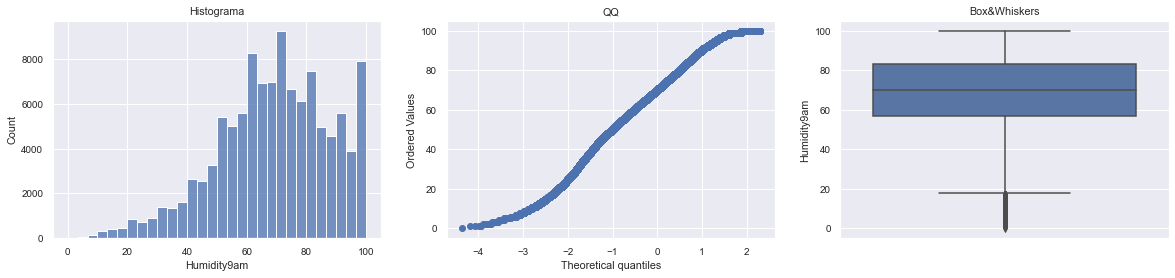

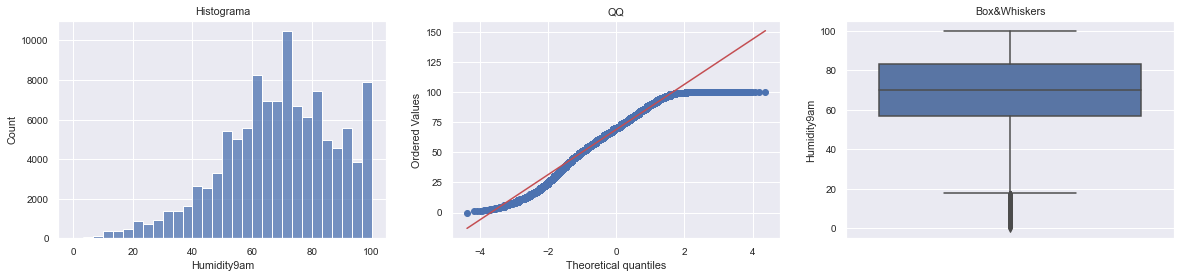

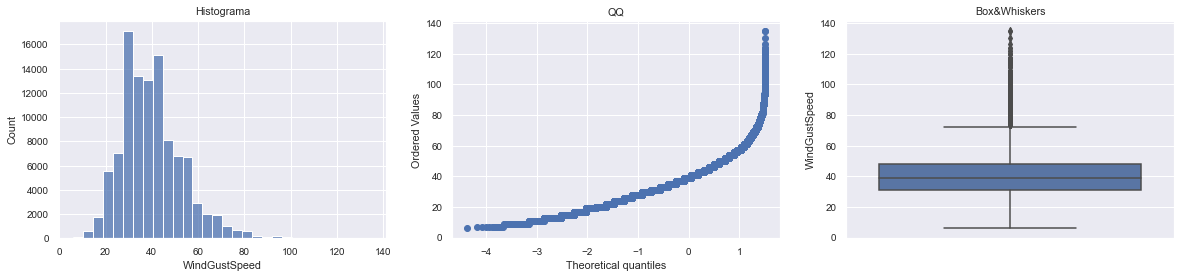

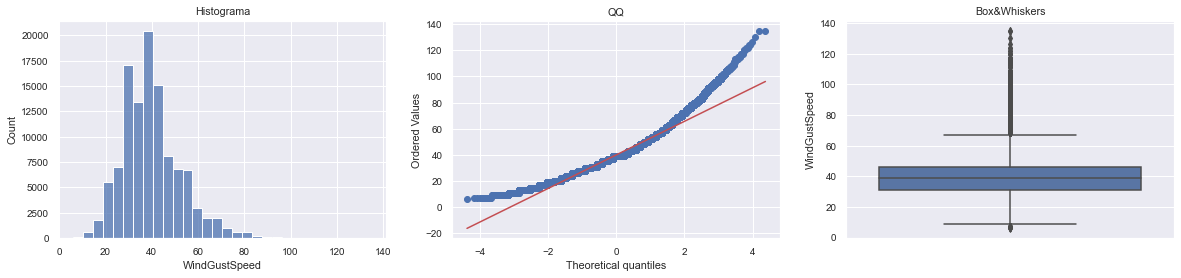

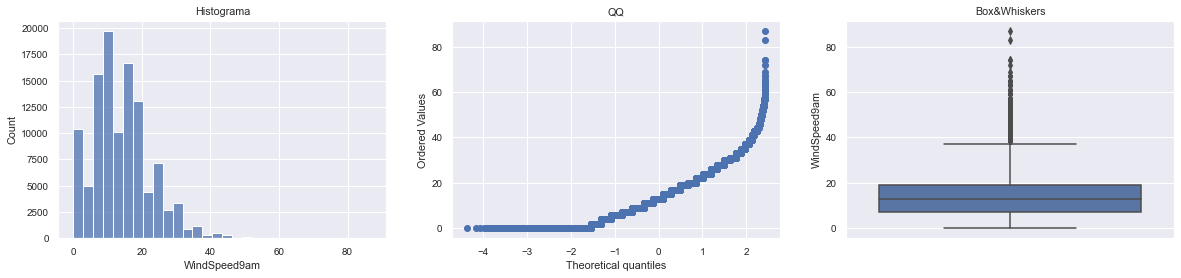

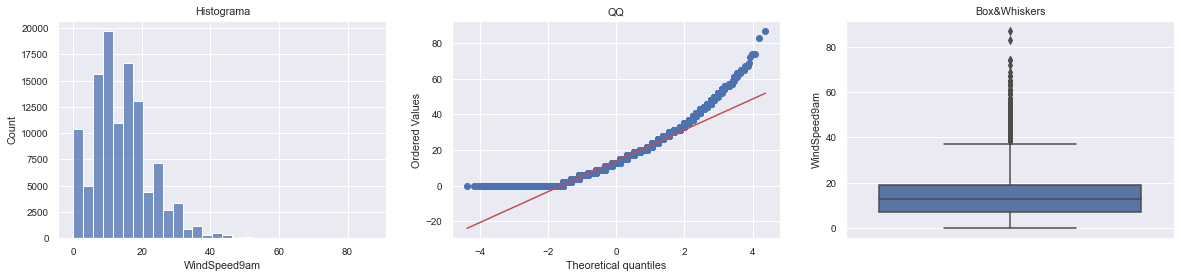

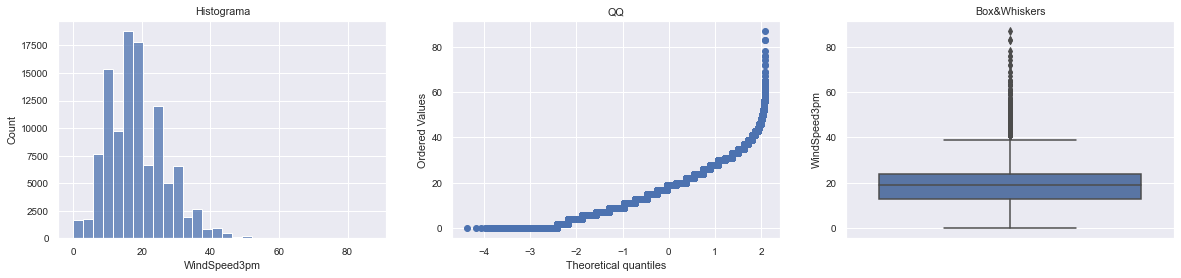

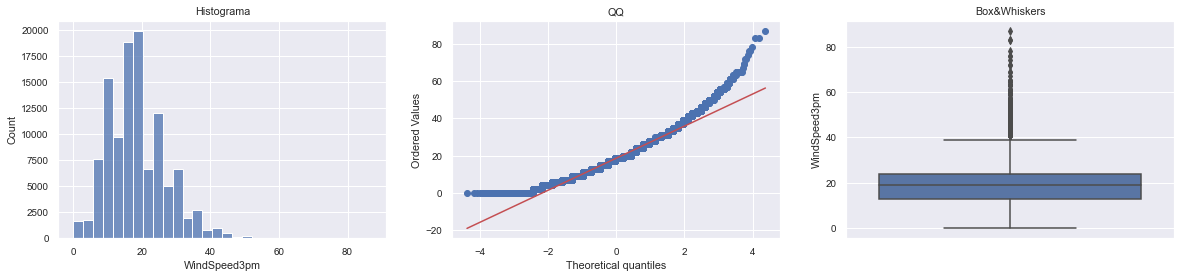

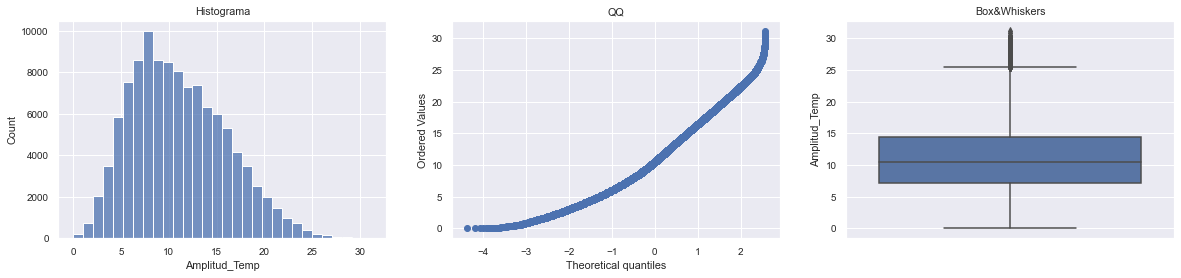

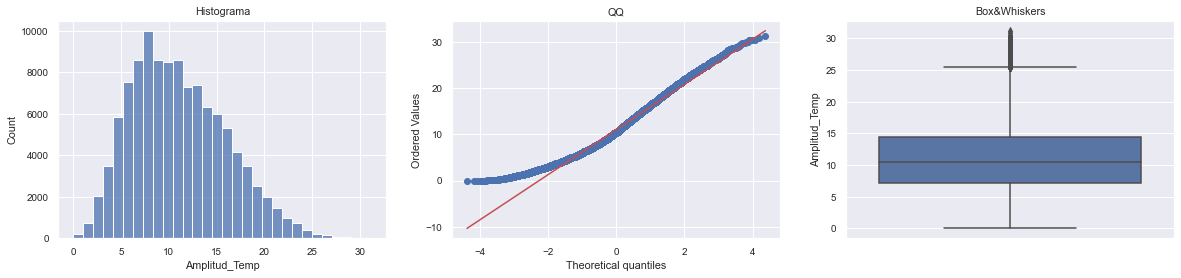

In [244]:
cols=["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]
X_medians = pd.DataFrame(columns=cols)
for column in cols:
    X_train, X_medians.loc[0,column]=impute_by_median(X_train,column)

X_train.isna().sum()

In [224]:
clusters=pd.unique(df_locations["Cluster"])
df_nans_per_cluster = pd.DataFrame(index=clusters, columns=X_train.columns)
for cluster in clusters:
    # Filas con y nulo
    clust=str(np.array([cluster]))
    df_cluster = X_train[X_train[clust]==1]
    for column in df_nans_per_cluster.columns:
        nans = len(df_cluster[df_cluster[column].isna()])
        df_nans_per_cluster.loc[cluster][column]=int(100*nans/len(df_cluster))
    df_nans_per_cluster=df_nans_per_cluster.drop(clust,axis=1)
#df_nans_per_cluster[["WindSpeed3pm","WindSpeed9am","WindGustSpeed","Humidity9am"]]
df_nans_per_cluster[["Humidity3pm","Pressure"]]

,Humidity3pm,Pressure
4,0,0
8,3,23
2,0,2
5,0,0
6,0,0
9,0,0
1,4,15
0,0,18
7,0,0
3,17,0


In [225]:
###########3 IMPUTACION POR KNN
from sklearn.impute import KNNImputer
def impute_by_KNN(X_t, n):
    X_train=X_t.copy()
    fig,axes=plt.subplots(len(X_train.columns),2,figsize=(15,12))
    # boxplot    
    i=0
    for column in X_train.columns:
        sns.boxplot(y=X_train[column],ax=axes[i,0])
        axes[i,0].set_title(str(column)+" original")
        i+=1

    imputer = KNNImputer(n_neighbors=n)
    X_KNN = imputer.fit_transform(X_train)
    X_KNN = pd.DataFrame(data=X_KNN, columns=X_train.columns, index=X_train.index)
    # boxplot    
    i=0
    for column in X_KNN.columns:
        sns.boxplot(y=X_KNN[column],ax=axes[i,1])
        axes[i,1].set_title(str(column)+" imputado")
        i+=1
    return X_KNN,imputer


In [226]:
###########3 IMPUTACION POR KNN
from sklearn.impute import KNNImputer
def impute_by_KNN2(X_t, n):
    X_train=X_t.copy()
    imputer = KNNImputer(n_neighbors=n)
    X_KNN = imputer.fit_transform(X_train)
    X_KNN = pd.DataFrame(data=X_KNN, columns=X_train.columns, index=X_train.index)
    return X_KNN,imputer

In [246]:
neighbors=5
Xt2, KNN_imputer=impute_by_KNN2(X_train[["Pressure","Humidity3pm","Amplitud_Temp"]],neighbors)

In [228]:
Xt2.head(), X_train[["Pressure","Humidity3pm"]].head()

(   Pressure  Humidity3pm  Amplitud_Temp
 0   1016.35         65.0            6.4
 1   1021.20         66.0            8.4
 2   1014.90         87.0            9.1
 3   1027.60         67.0            9.7
 4   1006.00         65.0            6.5,
    Pressure  Humidity3pm
 0   1016.35         65.0
 1   1021.20         66.0
 2   1014.90         87.0
 3   1027.60         67.0
 4   1006.00         65.0)

In [247]:
for column in ["Pressure","Humidity3pm"]:
    X_train[column]=Xt2[column]
X_train.isna().sum()

Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
RainToday            0
RainTomorrow         0
Rainfall_tomorrow    0
Verano               0
Otoño                0
Invierno             0
Primavera            0
WindGustDir_N        0
WindGustDir_S        0
WindGustDir_W        0
WindGustDir_E        0
WindDir9am_N         0
WindDir9am_S         0
WindDir9am_W         0
WindDir9am_E         0
WindDir3pm_N         0
WindDir3pm_S         0
WindDir3pm_W         0
WindDir3pm_E         0
[0]                  0
[1]                  0
[2]                  0
[3]                  0
[4]                  0
[5]                  0
[6]                  0
[7]                  0
[8]                  0
[9]                  0
Amplitud_Temp        0
Pressure             0
dtype: int64

In [230]:
X_train

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,RainToday,RainTomorrow,Rainfall_tomorrow,Verano,...,[2],[3],[4],[5],[6],[7],[8],[9],Amplitud_Temp,Pressure
0,22.0,43.0,19.0,22.0,75.0,65.0,1.0,0.0,0.6,0,...,0,0,0,0,0,0,0,0,6.4,1016.35
1,1.8,35.0,17.0,15.0,94.0,66.0,1.0,0.0,0.2,0,...,0,0,0,0,0,0,1,0,8.4,1021.20
2,4.2,33.0,11.0,11.0,93.0,87.0,1.0,1.0,8.0,0,...,0,0,0,0,0,0,1,0,9.1,1014.90
3,0.0,24.0,15.0,7.0,90.0,67.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,9.7,1027.60
4,8.8,30.0,13.0,13.0,82.0,65.0,1.0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,6.5,1006.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116324,0.0,37.0,20.0,28.0,55.0,46.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,8.6,1014.10
116325,0.0,33.0,19.0,20.0,65.0,50.0,0.0,0.0,0.0,1,...,0,0,1,0,0,0,0,0,22.4,1016.75
116326,0.0,30.0,11.0,11.0,33.0,18.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,19.1,1016.00
116327,0.0,22.0,9.0,9.0,67.0,39.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,15.4,1016.50


In [284]:
y_train=X_train["RainTomorrow"]
y_train_reg=X_train["Rainfall_tomorrow"]
X_train=X_train.drop(["RainTomorrow","Rainfall_tomorrow"],axis=1)

[Text(0.5, 0, 'Rainfall'),
 Text(1.5, 0, 'WindGustSpeed'),
 Text(2.5, 0, 'WindSpeed9am'),
 Text(3.5, 0, 'WindSpeed3pm'),
 Text(4.5, 0, 'Humidity9am'),
 Text(5.5, 0, 'Humidity3pm'),
 Text(6.5, 0, 'RainToday'),
 Text(7.5, 0, 'Verano'),
 Text(8.5, 0, 'Otoño'),
 Text(9.5, 0, 'Invierno'),
 Text(10.5, 0, 'Primavera'),
 Text(11.5, 0, 'WindGustDir_N'),
 Text(12.5, 0, 'WindGustDir_S'),
 Text(13.5, 0, 'WindGustDir_W'),
 Text(14.5, 0, 'WindGustDir_E'),
 Text(15.5, 0, 'WindDir9am_N'),
 Text(16.5, 0, 'WindDir9am_S'),
 Text(17.5, 0, 'WindDir9am_W'),
 Text(18.5, 0, 'WindDir9am_E'),
 Text(19.5, 0, 'WindDir3pm_N'),
 Text(20.5, 0, 'WindDir3pm_S'),
 Text(21.5, 0, 'WindDir3pm_W'),
 Text(22.5, 0, 'WindDir3pm_E'),
 Text(23.5, 0, '[0]'),
 Text(24.5, 0, '[1]'),
 Text(25.5, 0, '[2]'),
 Text(26.5, 0, '[3]'),
 Text(27.5, 0, '[4]'),
 Text(28.5, 0, '[5]'),
 Text(29.5, 0, '[6]'),
 Text(30.5, 0, '[7]'),
 Text(31.5, 0, '[8]'),
 Text(32.5, 0, '[9]'),
 Text(33.5, 0, 'Amplitud_Temp'),
 Text(34.5, 0, 'Pressure')]

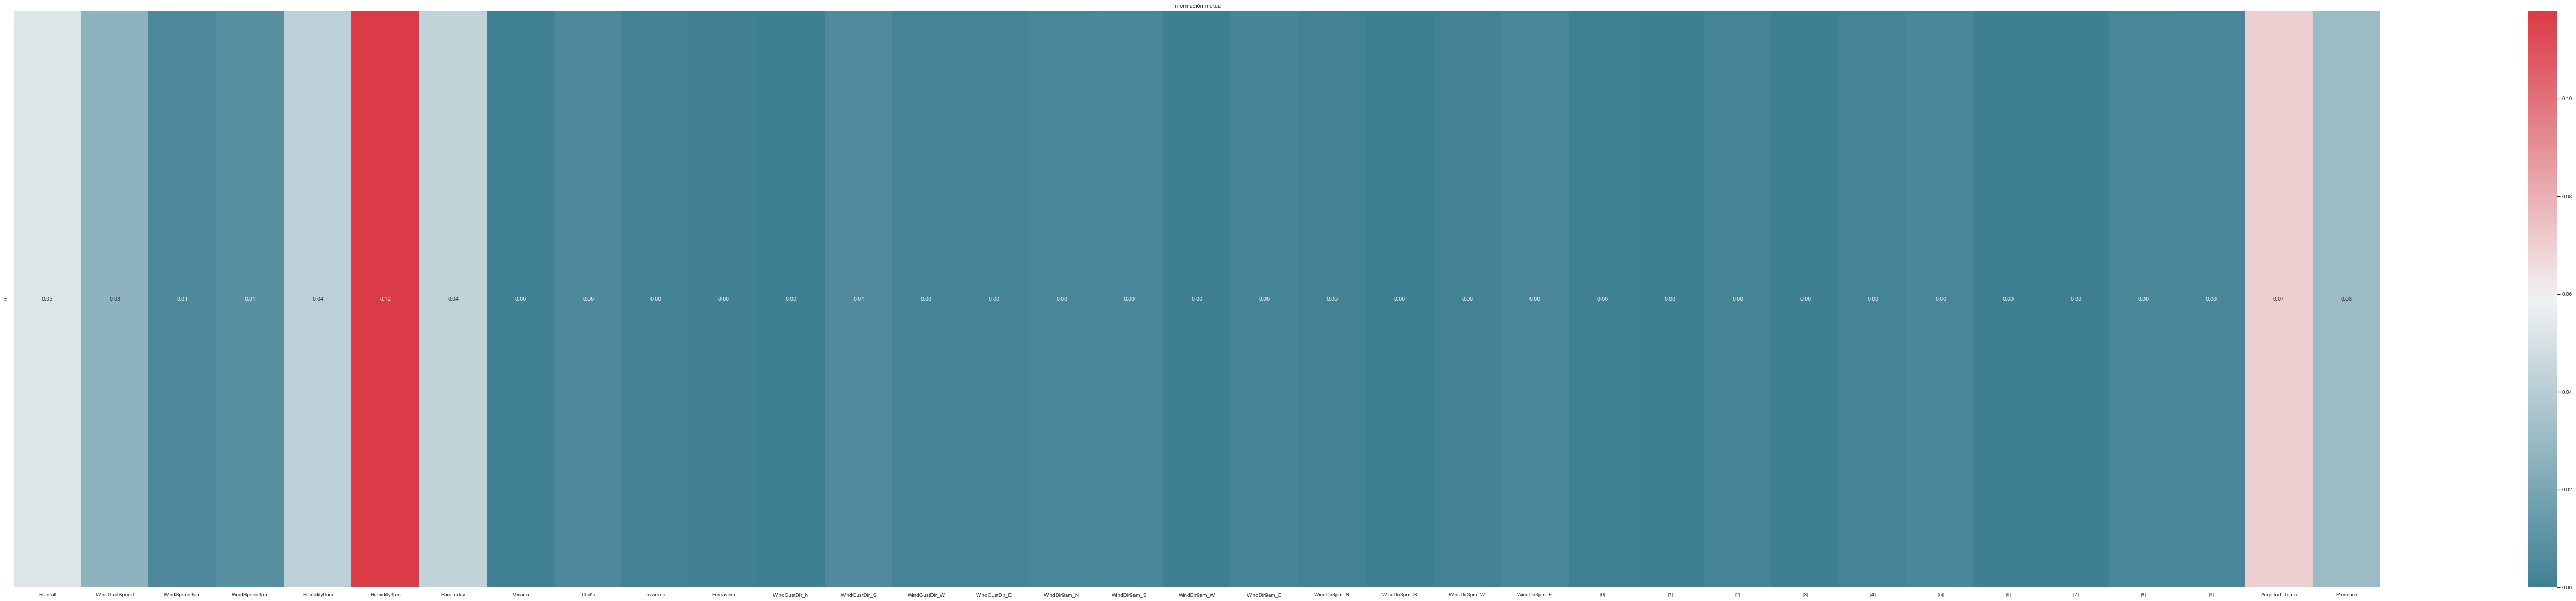

In [232]:
from sklearn.feature_selection import mutual_info_regression

MI = mutual_info_regression(X_train, y_train)
#fig, ax = plt.subplots(1,1, figsize=(100,20))
#ax.set_title('Información mutua')
#sns.heatmap([MI],ax=ax,cmap=sns.diverging_palette(220,10,as_cmap=True), annot=True,fmt=".2f")
#ax.set_xticklabels(X_train.columns)
MI = pd.DataFrame(data=100*MI,index=X_train.columns)
MI

,0
Rainfall,5.239921
WindGustSpeed,2.625375
WindSpeed9am,0.510955
WindSpeed3pm,0.896925
Humidity9am,4.174471
Humidity3pm,11.782180
RainToday,4.299968
Verano,0.090913
Otoño,0.467428
Invierno,0.162919


In [144]:
X_test.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Rainfall_tomorrow', 'Verano',
       'Otoño', 'Invierno', 'Primavera', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindGustDir_E', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir9am_E', 'WindDir3pm_N', 'WindDir3pm_S',
       'WindDir3pm_W', 'WindDir3pm_E', '[0]', '[1]', '[2]', '[3]', '[4]',
       '[5]', '[6]', '[7]', '[8]', '[9]'],
      dtype='object')

In [253]:
def poner_a_tono(df):
#    if "MaxTemp" and "MinTemp" in df.columns:
    df["Amplitud_Temp"]=df["MaxTemp"]-df["MinTemp"]
#    if "Pressure" not in df.columns:
    df=promedio(df, "Pressure9am", "Pressure3pm", "Pressure", True)
    cols_to_drop=["Date","MinTemp","MaxTemp","Cloud9am","Cloud3pm","Temp9am","Temp3pm","Pressure3pm","Pressure9am"]
#    for col in cols_to_drop:
 #       if col in df.columns:
#            df=df.drop(col,axis=1)
    df=df.drop(cols_to_drop, axis=1)
#### empezamos a ver los NaNs.
    df=df.dropna(subset=['Rainfall', 'Rainfall_tomorrow','RainToday','RainTomorrow'])
 ## imputaciones por mediana
    for col in ["Humidity9am","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Amplitud_Temp"]:
        df[col] = X_medians.loc[0,col].transform(df[col].values.reshape(-1,1))
### imputaciones por KNN
    df2=KNN_imputer.transform(df[["Pressure","Humidity3pm","Amplitud_Temp"]])
    df.loc[:,"Pressure"]=df2[:,0]
    df.loc[:,"Humidity3pm"]=df2[:,1]
    
    return df   

In [254]:
X_test=poner_a_tono(X_test)
X_test.head()

<ipython-input-253-fb228b5f70c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amplitud_Temp"]=df["MaxTemp"]-df["MinTemp"]
<ipython-input-169-fbddc21cdbf6>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[nombre] = df_prom.mean(axis=1, skipna=skipna)


,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,RainToday,RainTomorrow,Rainfall_tomorrow,Verano,...,[2],[3],[4],[5],[6],[7],[8],[9],Amplitud_Temp,Pressure
116329,0.2,48.0,24.0,28.0,58.0,47.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,7.2,1010.55
116330,0.0,39.0,15.0,19.0,35.0,16.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,15.6,1017.60
116331,0.0,30.0,0.0,20.0,79.0,55.0,0.0,0.0,0.2,0,...,0,0,1,0,0,0,0,0,16.1,1022.00
116332,0.0,50.0,28.0,35.0,61.0,52.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,0,0,7.5,1020.90
116333,0.0,37.0,15.0,11.0,63.0,35.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,10.0,1027.80


In [260]:
y_test=X_test["RainTomorrow"]
y_test_reg=X_test["Rainfall_tomorrow"]
X_test=X_test.drop(["Rainfall_tomorrow","RainTomorrow"],axis=1)

In [255]:
X_test.isna().sum()

Rainfall             0
WindGustSpeed        0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
RainToday            0
RainTomorrow         0
Rainfall_tomorrow    0
Verano               0
Otoño                0
Invierno             0
Primavera            0
WindGustDir_N        0
WindGustDir_S        0
WindGustDir_W        0
WindGustDir_E        0
WindDir9am_N         0
WindDir9am_S         0
WindDir9am_W         0
WindDir9am_E         0
WindDir3pm_N         0
WindDir3pm_S         0
WindDir3pm_W         0
WindDir3pm_E         0
[0]                  0
[1]                  0
[2]                  0
[3]                  0
[4]                  0
[5]                  0
[6]                  0
[7]                  0
[8]                  0
[9]                  0
Amplitud_Temp        0
Pressure             0
dtype: int64

In [307]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [308]:
pca = PCA(n_components=0.9, random_state=17).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [309]:
X_pca.shape[1]

23

In [310]:
X_pca.shape

(112605, 23)

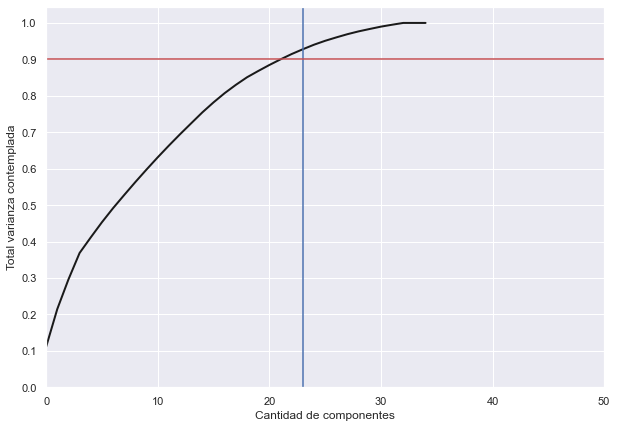

In [312]:
pca_2 = PCA(n_components=35, random_state=17).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 50)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(23, c='b')
plt.axhline(0.9, c='r')
plt.show()

Text(0.5, 1.0, 'HAR - PCA projection 2D')

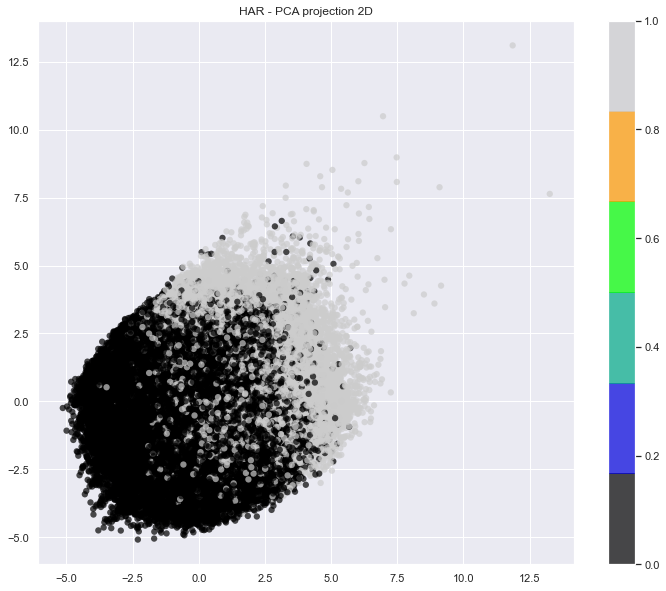

In [292]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('HAR - PCA projection 2D')

In [294]:
# Cantidad única de clases
clases = np.unique(y_train)
clases

array([0., 1.])

In [295]:
kmeans = KMeans(n_clusters=len(clases), n_init=100, random_state=17)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

In [302]:
X_pca.shape

(112605, 24)

Text(0.5, 1.0, 'HAR - PCA projection 2D')

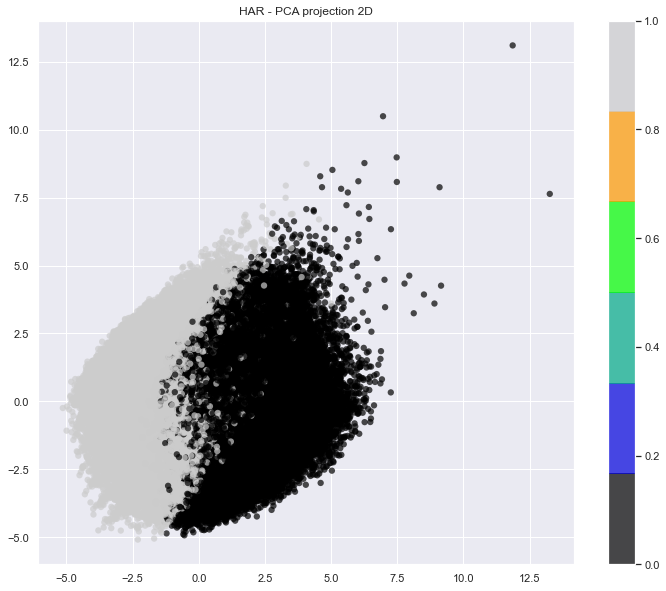

In [304]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('HAR - PCA projection 2D')

In [301]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ['Todos']
tab

,cluster 0,cluster 1,Todos
RainTomorrow,,,
0.0,40429,47236,87665
1.0,15788,9152,24940
All,56217,56388,112605


In [281]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented

In [335]:
class LogisticRegression2(BaseModel):
    
    # definimos la función sigmoid para entrenamiento y las predicciones
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # definimos la función loss para reportarla cada cierta cantidad de epochs
    def loss(self, y, y_hat):
        loss = np.mean(-y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
        return loss 

    def fit(self, X, y, lr, b, epochs, bias=True, log=100, verbose=True):

        # si decidimos utilizar bias, agregamos como siempre una columna con '1' al dataset de entrada
        if bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        # inicializamos aleatoriamente los pesos
        m = X.shape[1]
        W = np.random.randn(m).reshape(m, 1)

        loss_list = []
        
        # corremos Mini-Batch para optimizar los parámetros
        for j in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X_train = X[idx]
            y_train = y[idx]
            batch_size = int(len(X_train) / b)

            for i in range(0, len(X_train), batch_size):
                end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
                batch_X = X_train[i: end]
                batch_y = y_train[i: end]

                prediction = self.sigmoid(np.sum(np.transpose(W) * batch_X, axis=1))
                error = prediction.reshape(-1, 1) - batch_y.reshape(-1, 1)
                grad_sum = np.sum(error * batch_X, axis=0)
                grad_mul = 1 / batch_size * grad_sum
                gradient = np.transpose(grad_mul).reshape(-1, 1)

                W = W - (lr * gradient)
            
            l_epoch = self.loss(y_train, self.sigmoid(np.dot(X_train, W)))
            loss_list.append(l_epoch)
            if verbose:
                if j%log==0:
                    print("Epoch: {}, Loss: {}".format(j, l_epoch))
                
        self.model = W
        self.losses = loss_list

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        p = self.sigmoid(X @ self.model)
        mask_true = p >= 0.5
        mask_false = p < 0.5
        p[mask_true] = 1
        p[mask_false] = 0
        return p

In [320]:
X_pca[:, :2].shape

(112605, 2)

In [330]:
# Seleccionar hiperparámetros
lr = 0.05
b = 5
epochs = 300
bias = True

# Hacer el fit del modelo con los HPs seleccionados
logistic_regression = LogisticRegression2()
logistic_regression.fit(X_pca, y_train.values.reshape(-1, 1), lr, b, epochs, bias, log=100)
print(logistic_regression.model)

Epoch: 0, Loss: 1.8069229692831577
Epoch: 100, Loss: 0.3963642778060127
Epoch: 200, Loss: 0.385660438588122
[[-1.79343256]
 [ 0.31057427]
 [ 0.31891178]
 [-0.38581496]
 [ 0.58428605]
 [ 0.18173397]
 [ 0.10269369]
 [-0.0405741 ]
 [ 0.11319757]
 [-0.07328334]
 [ 0.06960269]
 [-0.03263557]
 [ 0.00666951]
 [ 0.01901633]
 [-0.00669928]
 [ 0.02661816]
 [-0.02433242]
 [ 0.05318529]
 [ 0.10979613]
 [-0.62221412]
 [-0.17902452]
 [-0.09115212]
 [ 0.05419676]
 [-0.27285578]]


In [322]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [323]:
X_test_pca.shape, y_test.shape

((28142, 23), (28142,))

In [331]:
predictions = logistic_regression.predict(X_test_pca)

In [386]:
def call_metrics(y_test, predictions):
    metrics = [Accuracy(), Precision(), Recall()]
    results = {}
    for metric in metrics:
        name = metric.__class__.__name__
        results[name] = metric(y_test, predictions)
        print('{metric}: {value}'.format(metric=name, value=results[name]))

In [387]:
call_metrics(y_test, predictions[:, 0])

Accuracy: 0.8327410987136664
Precision: 0.700180925303696
Recall: 0.4330242966751918


array([0., 0., 0., ..., 0., 1., 0.])

In [381]:
######### Segunda regresión logística con Sklearn
log_reg2=LogisticRegression(C=1.0, class_weight=None, penalty='l2',
                   random_state=None, solver='newton-cg')
log_reg2.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


LogisticRegression(solver='newton-cg')

In [382]:
predictions2 = log_reg2.predict(X_test)
predictions2

array([0., 0., 0., ..., 0., 1., 0.])

In [388]:
call_metrics(y_test, predictions2)

Accuracy: 0.8453912301897519
Precision: 0.7311332200922106
Recall: 0.48161764705882354


In [384]:
######### Tercera regresión logística con Sklearn, ahora con clases balanceadas
log_reg3=LogisticRegression(C=1.0, class_weight='balanced', penalty='l2',
                   random_state=None, solver='newton-cg')
log_reg3.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [389]:
predictions3 = log_reg3.predict(X_test)
predictions3

array([0., 0., 0., ..., 0., 1., 0.])

In [390]:
call_metrics(y_test, predictions3)

Accuracy: 0.7855518442186057
Precision: 0.5120095641778067
Recall: 0.753037084398977


In [362]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [391]:
RandomForestClassifier(class_weight=None,max_depth=None, n_estimators=200)

RandomForestClassifier(n_estimators=200)

In [364]:
predictions4=rfc.predict(X_test)

In [365]:
predictions4

array([0., 0., 0., ..., 0., 1., 0.])

In [366]:
metrics = [Accuracy(), Precision(), Recall()]
results = {}
for metric in metrics:
    name = metric.__class__.__name__
    results[name] = metric(y_test, predictions4)
    print('{metric}: {value}'.format(metric=name, value=results[name]))

Accuracy: 0.8563001918840167
Precision: 0.7654824771963514
Recall: 0.5097506393861893


In [372]:
X_train8=pd.concat([X_train, y_train, y_train_reg], axis=1, join="inner")
X_train8.columns

Index(['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'RainToday', 'Verano', 'Otoño',
       'Invierno', 'Primavera', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindGustDir_E', 'WindDir9am_N', 'WindDir9am_S',
       'WindDir9am_W', 'WindDir9am_E', 'WindDir3pm_N', 'WindDir3pm_S',
       'WindDir3pm_W', 'WindDir3pm_E', '[0]', '[1]', '[2]', '[3]', '[4]',
       '[5]', '[6]', '[7]', '[8]', '[9]', 'Amplitud_Temp', 'Pressure',
       'RainTomorrow', 'Rainfall_tomorrow'],
      dtype='object')

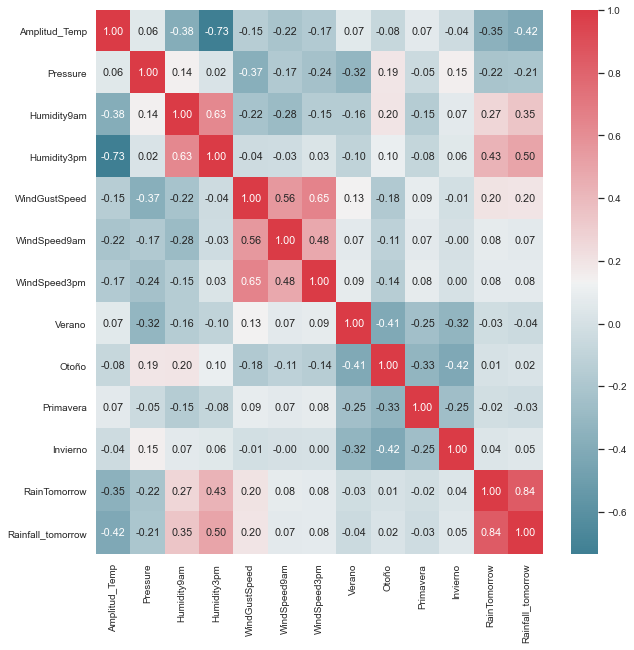

In [377]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_3=X_train8[["Amplitud_Temp","Pressure","Humidity9am","Humidity3pm","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Verano","Otoño","Primavera","Invierno","RainTomorrow","Rainfall_tomorrow"]]
corr_2 = df_3.corr(method='spearman')
sns.heatmap(corr_2, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f", ax=ax)
sns.set(font_scale=0.9)

In [378]:
SVM=SVC(C=0.01, kernel='linear')
SVM.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
predicciones4 = SVM.predict(X_test)